# Human vs AI Flappy Bird gameplay analysis

## Imports

In [4]:
import random
import time
import json
import base64
import csv
from google.colab import files
import datetime
from zoneinfo import ZoneInfo
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Flappy Bird no-GUI game engine

### Game-specific constants

In [5]:
GAME_WIDTH = 500
GAME_HEIGHT = 700

FIXED_DT = 0.0167

MAX_EPISODES = 30
MAX_FRAMES = 30000

### Classes

#### Bird class

In [6]:
class Bird:
  def __init__(self, game):
    self.game = game

    self.isFlapping = False
    self.flapCooldown = 0

    self.width = self.game.BIRD_WIDTH
    self.height = self.game.BIRD_HEIGHT

    self.x = self.game.GAME_WIDTH * self.game.BIRD_X_RATIO
    self._y = (self.game.GAME_HEIGHT - self.height) / 2

    self.velocity = 0

  @property
  def y(self):
    return self._y;
  @y.setter
  def y(self, v):
    if (v > self.game.GAME_HEIGHT or v < 0 - self.height):
      self.game.gameIsOver = True
    else:
     self._y = v;

  @property
  def hitbox(self):
    return {
        'x': self.x,
        'y': self.y,
        'width': self.width,
        'height': self.height,
    }

  def update(self, dt):
    self.flapCooldown = max(0, self.flapCooldown - dt)
    self.fall(dt)

  def reset(self):
    self.x = self.game.GAME_WIDTH * self.game.BIRD_X_RATIO
    self._y = (self.game.GAME_HEIGHT - self.height) / 2

    self.velocity = 0

  def fall(self, dt):
    self.velocity += self.game.GRAVITY * dt
    self.y += self.velocity * dt

  def flapWings(self):
    self.velocity = -300 # original
    #self.velocity = -275 # za llm

#### Pipes class

In [7]:
class Pipes:
  def __init__(self, game):
    self.game = game

    self.gap = self.game.PIPE_GAP

    self._x = self.game.PIPE_START_POINT
    self.topY = random.random() * (self.game.GAME_HEIGHT - self.gap)
    self.botY = self.topY + self.gap

    self.width = self.game.PIPE_WIDTH
    self.topHeight = self.topY
    self.botHeight = self.game.GAME_HEIGHT - self.botY

    self.velocity = self.game.PIPE_VELOCITY

    self.passed = False

  @property
  def x(self):
    return self._x
  @x.setter
  def x(self, v):
    if (v + self.width < 0):
      self.game.removePipePair(self)
    else:
      self._x = v

  @property
  def topHitbox(self):
    return {
        'x': self.x,
        'y': 0,
        'width': self.width,
        'height': self.topHeight,
    }
  @property
  def botHitbox(self):
    return {
        'x': self.x,
        'y': self.botY,
        'width': self.width,
        'height': self.botHeight,
    }

  def update(self, dt):
    self.x -= self.velocity * dt

  def reset(self):
    self.x = self.game.PIPE_START_POINT
    self.topY = random.random() * (self.game.GAME_HEIGHT - self.gap)
    self.botY = self.topY + self.gap

    self.topHeight = self.topY
    self.botHeight = self.game.GAME_HEIGHT - self.botY


#### Game class

In [8]:
class Game:
  def __init__(self, GAME_WIDTH, GAME_HEIGHT, record=False):
    self.record = record
    self.frameStates = [] if record else None
    self.episodeId = 0
    self.frameId = 0

    self.genome = None

    self.auto_reset = True

    self.AGENT_TYPE = "human"
    self.GAME_WIDTH = GAME_WIDTH
    self.GAME_HEIGHT = GAME_HEIGHT
    self.BIRD_X_RATIO = 0.3
    self.BIRD_WIDTH = 50
    self.BIRD_HEIGHT = 40
    self.GRAVITY = 600 # original
    #self.GRAVITY = 350 # za llm
    self.PIPE_START_POINT = 500
    self.PIPE_GAP = 200 # original
    #self.PIPE_GAP = 300 # za llm
    self.PIPE_WIDTH = 75
    self.PIPE_VELOCITY = 100
    self.PIPES_INTERVAL = 3

    self.pipesElapsed = 0

    self.bird = Bird(self)
    self.pipes = []

    self.gameIsOver = False

    self.points = 0

    self.metadata = {
        "agent_type": self.AGENT_TYPE,
        "game_width": self.GAME_WIDTH,
        "game_height": self.GAME_HEIGHT,
        "bird_x_ratio": self.BIRD_X_RATIO,
        "bird_width": self.BIRD_WIDTH,
        "bird_height": self.BIRD_HEIGHT,
        "gravity": self.GRAVITY,
        "pipe_gap": self.PIPE_GAP,
        "pipe_width": self.PIPE_WIDTH,
        "pipe_velocity": self.PIPE_VELOCITY,
        "pipes_interval": self.PIPES_INTERVAL,
    }

  def update(self, dt):
    for pipePair in self.pipes:
      if self.areColliding(self.bird.hitbox, pipePair.topHitbox) or \
      self.areColliding(self.bird.hitbox, pipePair.botHitbox):
        self.gameIsOver = True
        return

      if not(pipePair.passed) and self.bird.x > pipePair.x:
        self.points += 1
        pipePair.passed = True

      pipePair.update(dt)
    self.bird.update(dt)

  def gameLoop(self, dt):
    if not self.gameIsOver:
      self.update(dt)

    if self.gameIsOver:
      if not self.auto_reset:
        return
      if self.episodeId + 1 >= MAX_EPISODES:
        return

      self.gameIsOver = False
      self.reset()
    else:
      if self.record and len(self.frameStates) < MAX_FRAMES:
        self.frameStates.append({
            'episode_id': self.episodeId,
            'frame_id': self.frameId,
            'bird_y': self.bird.y,
            'bird_velocity': self.bird.velocity,
            'action': 1 if self.bird.isFlapping else 0,
            'pipe_pair_number': len(self.pipes),
            'pipes': (
                base64.b64encode(
                    json.dumps([
                        {
                            "x": pipe_pair.x,
                            "top_y": pipe_pair.topY,
                            "bot_y": pipe_pair.botY,
                            "passed": pipe_pair.passed
                        }
                        for pipe_pair in self.pipes
                    ]).encode("utf-8")
              ).decode("utf-8")
              if len(self.pipes) > 0 else 'null'
            ),
            'score': self.points,
            'game_is_over': 1 if self.gameIsOver else 0,
        })

      self.pipesElapsed += dt

      if self.pipesElapsed >= self.PIPES_INTERVAL:
        self.addPipePair()
        self.pipesElapsed = 0

      self.bird.isFlapping = False;
      self.frameId += 1

  def reset(self):
    self.episodeId += 1
    self.frameId = 0

    self.pipesElapsed = 0

    self.bird.reset()

    self.pipes = []

    self.points = 0

  def addPipePair(self):
    pipePair = Pipes(self)
    self.pipes.append(pipePair)
  def removePipePair(self, pipePair):
    if pipePair in self.pipes:
      self.pipes.remove(pipePair)

  def areColliding(self, bird, pipe):
    return bird['x'] < pipe['x'] + pipe['width'] and \
      bird['x'] + bird['width'] > pipe['x'] and \
      bird['y'] < pipe['y'] + pipe['height'] and \
      bird['y'] + bird['height'] > pipe['y'] - 30

## Genetic algorithm application

### GA-specific constants

In [9]:
POP_SIZE = 20
GENERATIONS = 30
ELITE_K = 5
TOP_N_GENS = 8
NUM_GENOMES = 5
EPISODES_PER_GENOME = 3

### GA helper functions

In [10]:
def random_genome():
  # Simplified genome - only 3 weights are enough
  return {
      "y_diff_weight": random.uniform(-1.0, 1.0),
      "vel_weight": random.uniform(-1.0, 1.0),
      "bias": random.uniform(-1.0, 1.0) # Bias is like threshold
  }

def mutate(genome):
  g = genome.copy()
  if random.random() < 0.5: # No reason to always mutate everything
    g["y_diff_weight"] += random.uniform(-0.2, 0.2)
  if random.random() < 0.5:
    g["vel_weight"] += random.uniform(-0.2, 0.2)
  if random.random() < 0.5:
    g["bias"] += random.uniform(-0.1, 0.1)
  return g

def fitness(game):
  # Rewarding survival and proximity to center of gap at the moment of death

  dist_to_center = 0
  pipe = next((p for p in game.pipes if p.x + game.PIPE_WIDTH > game.bird.x), None)
  if pipe:
    # Calculate by how much the center was missed (0 to Height)
    dist_to_center = abs(game.bird.y - (pipe.topY + pipe.botY) / 2)

  # Smaller dist_to_center = better fitness
  fitness_score = game.frameId + (game.points * 1000) - dist_to_center

  return max(0, fitness_score)

### GA agent class

In [11]:
class GAAgent:
  def __init__(self, genome):
    self.genome = genome

  def act(self, game):
    target_y = game.GAME_HEIGHT / 2
    pipe = next((p for p in game.pipes if p.x + game.PIPE_WIDTH > game.bird.x), None)

    if pipe:
        target_y = (pipe.topY + pipe.botY) / 2

    # Positive if bird is ABOVE gap (needs to fall)
    # Negative if bird is below gap (needs to flap)
    y_diff = (game.bird.y - target_y) / game.GAME_HEIGHT
    velocity = game.bird.velocity / 500 # Normalization

    decision = (
        self.genome["y_diff_weight"] * y_diff +
        self.genome["vel_weight"] * velocity +
        self.genome["bias"]
    )

    return 1 if decision > 0 else 0

### Run GA episode function

In [12]:
def run_episode(genome):
  game = Game(GAME_WIDTH, GAME_HEIGHT, record=False)
  game.AGENT_TYPE = "ga"

  agent = GAAgent(genome)

  while not(game.gameIsOver) and game.frameId < MAX_FRAMES:
    action = agent.act(game)

    if action == 1 and game.bird.flapCooldown <= 0:
      game.bird.isFlapping = True
      game.bird.flapWings()
      game.bird.flapCooldown = 0.15

    game.gameLoop(FIXED_DT)

  return fitness(game)

### Main GA loop

In [28]:
ga_log = []

population = [random_genome() for _ in range(POP_SIZE)]

global_best = float("-inf")
best_genome = None
best_genome_gen = None

generation_populations = {}

for gen in range(GENERATIONS):
  def run_episode_avg(genome, n=1):
    return sum(run_episode(genome) for _ in range(n)) / n

  scores = [run_episode_avg(g, n=3) for g in population]

  gen_best = max(scores)
  gen_mean = sum(scores) / len(scores)
  gen_min = min(scores)

  ga_log.append({
      "generation": gen,
      "best": gen_best,
      "mean": gen_mean,
      "min": gen_min,
  })

  print(f"Gen {gen}: best = {gen_best}")

  if gen_best > global_best:
    global_best = gen_best
    best_idx = scores.index(gen_best)
    best_genome = population[best_idx].copy()
    best_genome_gen = gen

  elite_idx = sorted(
      range(len(scores)),
      key=lambda i: scores[i],
      reverse=True
  )[:ELITE_K]

  elites = [population[i] for i in elite_idx]

  generation_populations[gen] = [g.copy() for g in population]

  population = elites + [
      mutate(random.choice(elites))
      for _ in range(POP_SIZE - ELITE_K)
  ]

top_generations = sorted(
    ga_log,
    key=lambda x: x["best"],
    reverse=True
)[:TOP_N_GENS]

selected_generations = [g["generation"] for g in top_generations]

print("Selected generations:", selected_generations)

selected_generation_populations = {
    gen: generation_populations[gen]
    for gen in selected_generations
}

Gen 0: best = 689.295569067331
Gen 1: best = 693.2714521692454
Gen 2: best = 1832.0138733302422
Gen 3: best = 2595.157692064916
Gen 4: best = 4499.612366660575
Gen 5: best = 3398.4076538390545
Gen 6: best = 5368.482518425052
Gen 7: best = 3844.956382174727
Gen 8: best = 4621.50480580601
Gen 9: best = 7333.927228027443
Gen 10: best = 22328.165172166326
Gen 11: best = 37302.60803845969
Gen 12: best = 28647.437578607667
Gen 13: best = 86066.86707626974
Gen 14: best = 194970.1451790292
Gen 15: best = 194988.94368240502
Gen 16: best = 194985.4242946241
Gen 17: best = 194988.28771357305
Gen 18: best = 194981.62589944576
Gen 19: best = 194987.29428984257
Gen 20: best = 194986.96737260418
Gen 21: best = 194991.2808174333
Gen 22: best = 194965.18935023018
Gen 23: best = 194980.92635840495
Gen 24: best = 194980.4356616186
Gen 25: best = 194972.35161433695
Gen 26: best = 194978.09877311412
Gen 27: best = 194980.39229554075
Gen 28: best = 194966.27314986184
Gen 29: best = 194985.14142252828
Select

### Replay best genome

In [29]:
all_frames = []
episode_id = 0

for gen_id, population in selected_generation_populations.items():
  sampled_genomes = random.sample(
      population,
      min(NUM_GENOMES, len(population))
  )

  print(f"Replaying generation {gen_id} "
        f"({len(sampled_genomes)} genomes)")

  for genome_idx, genome in enumerate(sampled_genomes):
    for run in range(EPISODES_PER_GENOME):
      print(f"  gen {gen_id} | genome {genome_idx} | episode {episode_id}")

      game = Game(GAME_WIDTH, GAME_HEIGHT, record=True)
      game.AGENT_TYPE = "ga"

      agent = GAAgent(genome)

      for _ in range(MAX_FRAMES):
        if game.gameIsOver:
          break

        action = agent.act(game)

        if action == 1 and game.bird.flapCooldown <= 0:
          game.bird.isFlapping = True
          game.bird.flapWings()
          game.bird.flapCooldown = 0.15

        game.gameLoop(FIXED_DT)

      for frame in game.frameStates:
        frame["episode_id"] = episode_id
        frame["generation"] = gen_id
        frame["genome_id"] = genome_idx

      all_frames.extend(game.frameStates)

      print(f"    score={game.points}")

      episode_id += 1

print("Replay finished")
print("Total GA episodes:", episode_id)
print("Total GA frames:", len(all_frames))

Replaying generation 21 (5 genomes)
  gen 21 | genome 0 | episode 0
    score=0
  gen 21 | genome 0 | episode 1
    score=23
  gen 21 | genome 0 | episode 2
    score=16
  gen 21 | genome 1 | episode 3
    score=0
  gen 21 | genome 1 | episode 4
    score=0
  gen 21 | genome 1 | episode 5
    score=1
  gen 21 | genome 2 | episode 6
    score=0
  gen 21 | genome 2 | episode 7
    score=50
  gen 21 | genome 2 | episode 8
    score=30
  gen 21 | genome 3 | episode 9
    score=165
  gen 21 | genome 3 | episode 10
    score=165
  gen 21 | genome 3 | episode 11
    score=165
  gen 21 | genome 4 | episode 12
    score=165
  gen 21 | genome 4 | episode 13
    score=165
  gen 21 | genome 4 | episode 14
    score=165
Replaying generation 15 (5 genomes)
  gen 15 | genome 0 | episode 15
    score=26
  gen 15 | genome 0 | episode 16
    score=12
  gen 15 | genome 0 | episode 17
    score=2
  gen 15 | genome 1 | episode 18
    score=0
  gen 15 | genome 1 | episode 19
    score=1
  gen 15 | genome 1 

## Export GA game zip

### Export frames.csv

In [30]:
frames_headers = list(all_frames[0].keys())
frames_csv = "frames.csv"

with open(frames_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(frames_headers)
    writer.writerows(
        [[frame[h] for h in frames_headers] for frame in all_frames]
    )

print(f"Saved a total of {len(all_frames)} frames.")

Saved a total of 2809442 frames.


### Export GA metadata.csv

In [31]:
game.metadata.update({
    "agent_type": "ga",
    "ga_population_size": POP_SIZE,
    "ga_generations": GENERATIONS,
    "best_genome_generation": best_genome_gen,
    "total_episodes_recorded": episode_id,
    "max_frames_per_episode": MAX_FRAMES,
})

metadata_csv = "metadata.csv"
meta_keys = list(game.metadata.keys())
meta_values = list(game.metadata.values())

with open(metadata_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(meta_keys)
    writer.writerow(meta_values)

### Zip & download game

In [32]:
now = datetime.datetime.now(ZoneInfo("Europe/Zagreb"))
timestamp = now.strftime("%Y%m%d_%H%M%S")
zip_filename = f"flappy_bird_ga_replay_{timestamp}.zip"

with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(frames_csv)
    zipf.write(metadata_csv)

files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data-Driven Analysis of Human and AI (GA) Gameplay Behavior (WIP: DATA LEAK)

The purpose of this exploratory data analysis is to obtain an initial understanding of the gameplay data generated by human players and a Genetic Algorithm (GA) agent in the Flappy Bird environment. Unlike static benchmark datasets, this dataset consists of frame-level observations that capture continuous player behavior throughout each episode, a "run" of the game from start to end (agent coming in collision with a boundary of the game or pipe, or when the frame limit of 30000 recorded frames in a single episode is reached which should be signified by a score of approximately 165).

This analysis focuses on examining the structure, quality, and distributions of key gameplay variables, including bird position, velocity, actions, score progression, and the presence of pipes across frames. Special attention is given to differences in episode structure between human gameplay, which consists of multiple shorter episodes, and GA gameplay, which represents a single long, optimized run.

By comparing descriptive statistics, action frequencies and pipe-related features, this section aims to reveal "hard-to-notice" behavioral differences between human and GA agents and to inform subsequent analytical steps, such as behavioral clustering and predictive modeling.

### Importing data

#### Unzip both datasets

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/Human Vs AI Flappy Bird Gameplay Analysis"

def unzip_to_folder(zip_name, out_folder):
  zip_path = os.path.join(BASE_PATH, zip_name)
  out_path = os.path.join(BASE_PATH, out_folder)
  os.makedirs(out_path, exist_ok=True)

  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(out_path)

  return out_path

human_path = unzip_to_folder("flappy_bird_game_20260118_225542.zip", "human")
ga_path = unzip_to_folder("flappy_bird_ga_replay_20260118_184431.zip", "ga")

#### Load CSVs

In [ ]:
human_frames = pd.read_csv(f"{human_path}/frames.csv")
ga_frames = pd.read_csv(f"{ga_path}/frames.csv")

human_meta = pd.read_csv(f"{human_path}/metadata.csv")
ga_meta = pd.read_csv(f"{ga_path}/metadata.csv")

#### Correct import check

In [ ]:
print('--- human_frames head (shape: {}) ---'.format(human_frames.shape))
display(human_frames.head())

print('\n--- ga_frames head (shape: {}) ---'.format(ga_frames.shape))
display(ga_frames.head())

print('\n--- human_meta head (shape: {}) ---'.format(human_meta.shape))
display(human_meta.head())

print('\n--- ga_meta head (shape: {}) ---'.format(ga_meta.shape))
display(ga_meta.head())

--- human_frames head (shape: (32211, 9)) ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,pipes,score,game_is_over
0,0,0,330.000000,0.00,0,0,NaN,0,0
1,0,1,330.167334,10.02,0,0,NaN,0,0
2,0,2,330.502002,20.04,0,0,NaN,0,0
3,0,3,331.004004,30.06,0,0,NaN,0,0
4,0,4,331.673340,40.08,0,0,NaN,0,0



--- ga_frames head (shape: (30000, 9)) ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,pipes,score,game_is_over
0,0,0,330.167334,10.02,0,0,NaN,0,0
1,0,1,330.502002,20.04,0,0,NaN,0,0
2,0,2,331.004004,30.06,0,0,NaN,0,0
3,0,3,331.673340,40.08,0,0,NaN,0,0
4,0,4,332.510010,50.10,0,0,NaN,0,0



--- human_meta head (shape: (1, 11)) ---


,agent_type,game_width,game_height,bird_x_ratio,bird_width,bird_height,gravity,pipe_gap,pipe_width,pipe_velocity,pipes_interval
0,human,500,700,0.3,50,40,600,200,75,100,3



--- ga_meta head (shape: (1, 16)) ---


,agent_type,game_width,game_height,bird_x_ratio,bird_width,bird_height,gravity,pipe_gap,pipe_width,pipe_velocity,pipes_interval,ga_population_size,ga_generations,best_genome_generation,best_genome,max_frames
0,ga,500,700,0.3,50,40,600,200,75,100,3,20,30,28,"{""y_diff_weight"": 1.6080582416293712, ""vel_wei...",30000


### Normalizing, cleaning and restructuring data

In [ ]:
# Just in case the data was already changed
human_frames = pd.read_csv(f"{human_path}/frames.csv")
ga_frames = pd.read_csv(f"{ga_path}/frames.csv")

human_meta = pd.read_csv(f"{human_path}/metadata.csv")
ga_meta = pd.read_csv(f"{ga_path}/metadata.csv")

def clean_frames_and_extract_pipes(df_input, agent_type_str):
  df_process = df_input.copy()
  df_process['has_pipe_in_frame'] = 0
  pipe_records = []

  for index, row in df_process.iterrows():
    episode_id = row['episode_id']
    frame_id = row['frame_id']
    encoded_data = row['pipes']

    decoded_pipes = []

    if pd.notna(encoded_data) and encoded_data != 'null':
      try:
        decoded_bytes = base64.b64decode(encoded_data)
        decoded_pipes = json.loads(decoded_bytes.decode('utf-8'))
      except Exception:
        decoded_pipes = []

    if len(decoded_pipes) > 0:
      df_process.at[index, 'has_pipe_in_frame'] = 1
    df_process.at[index, 'num_pipes_in_frame'] = len(decoded_pipes)

    for pipe_idx, pipe_data in enumerate(decoded_pipes):
      pipe_records.append({
          'episode_id': episode_id,
          'frame_id': frame_id,
          'pipe_index_in_frame': pipe_idx,
          'agent_type': agent_type_str,
          'pipe_x': pipe_data['x'],
          'pipe_top_y': pipe_data['top_y'],
          'pipe_bot_y': pipe_data['bot_y'],
          'pipe_passed': pipe_data['passed']
      })

  df_cleaned_frames = df_process.drop(columns=['pipes'])

  pipe_level_df = pd.DataFrame(pipe_records)

  return df_cleaned_frames, pipe_level_df

In [ ]:
print("Applying cleaning and pipe extraction for human_frames...")
human_frames, human_pipe_data = clean_frames_and_extract_pipes(human_frames, 'human')

print("Applying cleaning and pipe extraction for ga_frames...")
ga_frames, ga_pipe_data = clean_frames_and_extract_pipes(ga_frames, 'ga')

all_pipe_level_data = pd.concat(
    [human_pipe_data, ga_pipe_data],
    ignore_index=True
)

Applying cleaning and pipe extraction for human_frames...
Applying cleaning and pipe extraction for ga_frames...


In [ ]:
print("\n--- Human Frame-Level Data Head ---")
display(human_frames.head())

print("\n--- GA Frame-Level Data Head ---")
display(ga_frames.head())

print("\n--- Pipe-Level Data Head ---")
display(all_pipe_level_data.head())

output_dir = "cleaned_data"
os.makedirs(output_dir, exist_ok=True)

human_frames.to_csv(
    os.path.join(output_dir, "human_frames_cleaned.csv"),
    index=False
)
ga_frames.to_csv(
    os.path.join(output_dir, "ga_frames_cleaned.csv"),
    index=False
)
all_pipe_level_data.to_csv(
    os.path.join(output_dir, "all_pipe_data_normalized.csv"),
    index=False
)

print(f"\nCleaned data exported to '{output_dir}' directory.")


--- Human Frame-Level Data Head ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,score,game_is_over,has_pipe_in_frame,num_pipes_in_frame
0,0,0,330.000000,0.00,0,0,0,0,0,0.0
1,0,1,330.167334,10.02,0,0,0,0,0,0.0
2,0,2,330.502002,20.04,0,0,0,0,0,0.0
3,0,3,331.004004,30.06,0,0,0,0,0,0.0
4,0,4,331.673340,40.08,0,0,0,0,0,0.0



--- GA Frame-Level Data Head ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,score,game_is_over,has_pipe_in_frame,num_pipes_in_frame
0,0,0,330.167334,10.02,0,0,0,0,0,0.0
1,0,1,330.502002,20.04,0,0,0,0,0,0.0
2,0,2,331.004004,30.06,0,0,0,0,0,0.0
3,0,3,331.673340,40.08,0,0,0,0,0,0.0
4,0,4,332.510010,50.10,0,0,0,0,0,0.0



--- Pipe-Level Data Head ---


,episode_id,frame_id,pipe_index_in_frame,agent_type,pipe_x,pipe_top_y,pipe_bot_y,pipe_passed
0,0,181,0,human,498.33,394.278765,594.278765,False
1,0,182,0,human,496.66,394.278765,594.278765,False
2,0,183,0,human,494.99,394.278765,594.278765,False
3,0,184,0,human,493.32,394.278765,594.278765,False
4,0,185,0,human,491.65,394.278765,594.278765,False



Cleaned data exported to 'cleaned_data' directory.


The original frame-level dataset contained a pipes column storing pipe information as base64-encoded JSON (to remedy the potential CSV comma in value problem), resulting in a nested and non-relational structure. To enable structured analysis and modeling, this step transforms the raw data into a normalized relational format.

Specifically, the data is decomposed into two linked tables:

A frame-level table, where each row represents a single game frame and contains bird state variables and game metadata.

A pipe-level table, where each row represents an individual pipe visible at a given frame, linked back to the corresponding frame via episode_id and frame_id.

This transformation enforces a one-to-many (1:n) relationship between frames and pipes, ensuring compliance with first normal form (1NF). In addition, a binary indicator (has_pipe_in_frame) is constructed at the frame level to capture whether any pipes are visible in a given frame. This variable serves as a lightweight structural feature that simplifies downstream analysis without introducing model-specific assumptions.

Overall, this step primarily constitutes data normalization, with minor data cleaning and limited "feature engineering" to improve interpretability and analytical flexibility.

### Feature Engineering

#### New feature definitions

In [ ]:
output_dir = "cleaned_data"

human_frames_cleaned = pd.read_csv(os.path.join(output_dir, "human_frames_cleaned.csv"))
ga_frames_cleaned = pd.read_csv(os.path.join(output_dir, "ga_frames_cleaned.csv"))
all_pipe_data_normalized = pd.read_csv(os.path.join(output_dir, "all_pipe_data_normalized.csv"))

human_meta = pd.read_csv(f"{human_path}/metadata.csv")
ga_meta = pd.read_csv(f"{ga_path}/metadata.csv")

FIXED_DT = 0.0167

def compute_behavioral_features(df_frames, df_all_pipes, game_width, game_height, bird_x_ratio, pipe_width):
  df = df_frames.copy()

  df['episode_id'] = df['episode_id'].astype(int)
  df['frame_id'] = df['frame_id'].astype(int)
  df_all_pipes['episode_id'] = df_all_pipes['episode_id'].astype(int)
  df_all_pipes['frame_id'] = df_all_pipes['frame_id'].astype(int)

  bird_x_fixed = game_width * bird_x_ratio

  df['abs_velocity'] = df['bird_velocity'].abs()

  df['last_flap_frame'] = df.groupby('episode_id')['frame_id'].transform(
    lambda x: x.where(df.loc[x.index, 'action'] == 1).ffill()
  )
  df['time_since_last_flap'] = (df['frame_id'] - df['last_flap_frame']) * FIXED_DT
  df.drop(columns=['last_flap_frame'], inplace=True)

  df['min_dist_to_boundary'] = np.minimum(df['bird_y'], game_height - df['bird_y'])

  df_all_pipes_processed = df_all_pipes.copy()
  df_all_pipes_processed['pipe_center_y'] = (df_all_pipes_processed['pipe_top_y'] + df_all_pipes_processed['pipe_bot_y']) / 2

  relevant_pipes_df = df_all_pipes_processed[
      df_all_pipes_processed['pipe_x'] + pipe_width > bird_x_fixed
  ].copy()

  next_pipes_info = None
  if not relevant_pipes_df.empty:
    idx = relevant_pipes_df.groupby(['episode_id', 'frame_id'])['pipe_x'].idxmin()
    next_pipes_info = relevant_pipes_df.loc[idx].copy()

    next_pipes_info = next_pipes_info[[
        'episode_id', 'frame_id', 'pipe_x', 'pipe_top_y', 'pipe_bot_y', 'pipe_center_y'
    ]]
    next_pipes_info.rename(columns={
        'pipe_x': 'next_pipe_x',
        'pipe_top_y': 'next_pipe_top_y',
        'pipe_bot_y': 'next_pipe_bot_y',
        'pipe_center_y': 'next_pipe_center_y'
    }, inplace=True)
  else:
    next_pipes_info = pd.DataFrame(columns=[
        'episode_id', 'frame_id', 'next_pipe_x', 'next_pipe_top_y', 'next_pipe_bot_y', 'next_pipe_center_y'
    ])

  df = pd.merge(df, next_pipes_info, on=['episode_id', 'frame_id'], how='left')

  df['dist_to_next_pipe_x'] = df['next_pipe_x'] - bird_x_fixed
  df['dist_to_next_pipe_center_y'] = (df['bird_y'] - df['next_pipe_center_y']).abs()

  df.drop(columns=['next_pipe_x', 'next_pipe_top_y', 'next_pipe_bot_y', 'next_pipe_center_y'], inplace=True)

  return df

#### Apply feature engineering

In [ ]:
features_output_dir = "features_data"
os.makedirs(features_output_dir, exist_ok=True)

print("Computing features for human frames...")
human_frames_features = compute_behavioral_features(
    human_frames_cleaned,
    all_pipe_data_normalized,
    game_width=human_meta['game_width'].iloc[0],
    game_height=human_meta['game_height'].iloc[0],
    bird_x_ratio=human_meta['bird_x_ratio'].iloc[0],
    pipe_width=human_meta['pipe_width'].iloc[0]
)
print(f"New human_frames_features shape: {human_frames_features.shape}")

print("Computing features for GA frames...")
ga_frames_features = compute_behavioral_features(
    ga_frames_cleaned,
    all_pipe_data_normalized,
    game_width=ga_meta['game_width'].iloc[0],
    game_height=ga_meta['game_height'].iloc[0],
    bird_x_ratio=ga_meta['bird_x_ratio'].iloc[0],
    pipe_width=ga_meta['pipe_width'].iloc[0]
)
print(f"New ga_frames_features shape: {ga_frames_features.shape}")

Computing features for human frames...
New human_frames_features shape: (32211, 15)
Computing features for GA frames...
New ga_frames_features shape: (30000, 15)


#### Save results

In [ ]:
human_frames_features.to_csv(
    os.path.join(features_output_dir, "human_frames_features.csv"),
    index=False
)
ga_frames_features.to_csv(
    os.path.join(features_output_dir, "ga_frames_features.csv"),
    index=False
)

print(f"\nFeature engineered data saved to '{features_output_dir}' directory:")
print(" - human_frames_features.csv")
print(" - ga_frames_features.csv")

print("\n--- Displaying head of human_frames_features (first 5 rows) ---")
display(human_frames_features.head())

print("\n--- Displaying head of ga_frames_features (first 5 rows) ---")
display(ga_frames_features.head())


Feature engineered data saved to 'features_data' directory:
 - human_frames_features.csv
 - ga_frames_features.csv

--- Displaying head of human_frames_features (first 5 rows) ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,score,game_is_over,has_pipe_in_frame,num_pipes_in_frame,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y
0,0,0,330.000000,0.00,0,0,0,0,0,0.0,0.00,NaN,330.000000,NaN,NaN
1,0,1,330.167334,10.02,0,0,0,0,0,0.0,10.02,NaN,330.167334,NaN,NaN
2,0,2,330.502002,20.04,0,0,0,0,0,0.0,20.04,NaN,330.502002,NaN,NaN
3,0,3,331.004004,30.06,0,0,0,0,0,0.0,30.06,NaN,331.004004,NaN,NaN
4,0,4,331.673340,40.08,0,0,0,0,0,0.0,40.08,NaN,331.673340,NaN,NaN



--- Displaying head of ga_frames_features (first 5 rows) ---


,episode_id,frame_id,bird_y,bird_velocity,action,pipe_pair_number,score,game_is_over,has_pipe_in_frame,num_pipes_in_frame,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y
0,0,0,330.167334,10.02,0,0,0,0,0,0.0,10.02,NaN,330.167334,NaN,NaN
1,0,1,330.502002,20.04,0,0,0,0,0,0.0,20.04,NaN,330.502002,NaN,NaN
2,0,2,331.004004,30.06,0,0,0,0,0,0.0,30.06,NaN,331.004004,NaN,NaN
3,0,3,331.673340,40.08,0,0,0,0,0,0.0,40.08,NaN,331.673340,NaN,NaN
4,0,4,332.510010,50.10,0,0,0,0,0,0.0,50.10,NaN,332.510010,NaN,NaN


#### Engineered features:
*   `abs_velocity`: Absolute vertical velocity, indicating intensity of vertical movement regardless of direction
*   `time_since_last_flap`: Time elapsed since the last flap action, capturing flap rhythm and responsiveness
*   `min_dist_to_boundary`: Minimum of distance from top boundary and distance from bottom boundary, indicating proximity to either vertical boundary
*   `dist_to_next_pipe_x`: Horizontal distance from the bird's fixed X-position to the next pipe's left edge
*   `dist_to_next_pipe_center_y`: Vertical distance from the bird to the center of the next pipe's gap

### Exploratory data analysis

#### `human_frames` inspection

In [ ]:
print('--- human_frames.info() ---')
human_frames.info()
print('\n--- human_frames.isnull().sum() ---')
display(human_frames.isnull().sum())

--- human_frames.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32211 entries, 0 to 32210
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   episode_id          32211 non-null  int64  
 1   frame_id            32211 non-null  int64  
 2   bird_y              32211 non-null  float64
 3   bird_velocity       32211 non-null  float64
 4   action              32211 non-null  int64  
 5   pipe_pair_number    32211 non-null  int64  
 6   score               32211 non-null  int64  
 7   game_is_over        32211 non-null  int64  
 8   has_pipe_in_frame   32211 non-null  int64  
 9   num_pipes_in_frame  32211 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 2.5 MB

--- human_frames.isnull().sum() ---


,0
episode_id,0
frame_id,0
bird_y,0
bird_velocity,0
action,0
pipe_pair_number,0
score,0
game_is_over,0
has_pipe_in_frame,0
num_pipes_in_frame,0


The pipes column contains missing (NaN) values, which are expected and represent frames in which no pipes are present on the screen. This situation occurs exclusively at the beginning of each episode, before the first pipe pair is generated. As such, these missing values are structural and do not indicate data quality issues.

#### `ga_frames` inspection

In [ ]:
print('--- ga_frames.info() ---')
ga_frames.info()
print('\n--- ga_frames.isnull().sum() ---')
display(ga_frames.isnull().sum())

--- ga_frames.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   episode_id          30000 non-null  int64  
 1   frame_id            30000 non-null  int64  
 2   bird_y              30000 non-null  float64
 3   bird_velocity       30000 non-null  float64
 4   action              30000 non-null  int64  
 5   pipe_pair_number    30000 non-null  int64  
 6   score               30000 non-null  int64  
 7   game_is_over        30000 non-null  int64  
 8   has_pipe_in_frame   30000 non-null  int64  
 9   num_pipes_in_frame  30000 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 2.3 MB

--- ga_frames.isnull().sum() ---


,0
episode_id,0
frame_id,0
bird_y,0
bird_velocity,0
action,0
pipe_pair_number,0
score,0
game_is_over,0
has_pipe_in_frame,0
num_pipes_in_frame,0


The number of missing pipes entries differs significantly between human and GA gameplay data. Human gameplay consists of multiple episodes, each introducing an initial period without pipes, while the GA dataset contains significantly fewer episode restarts. Consequently, the proportion of frames without pipes is substantially lower in the GA data.

#### `human_meta` inspection

In [ ]:
print('--- human_meta.info() ---')
human_meta.info()
print('\n--- human_meta.isnull().sum() ---')
display(human_meta.isnull().sum())

--- human_meta.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   agent_type      1 non-null      object 
 1   game_width      1 non-null      int64  
 2   game_height     1 non-null      int64  
 3   bird_x_ratio    1 non-null      float64
 4   bird_width      1 non-null      int64  
 5   bird_height     1 non-null      int64  
 6   gravity         1 non-null      int64  
 7   pipe_gap        1 non-null      int64  
 8   pipe_width      1 non-null      int64  
 9   pipe_velocity   1 non-null      int64  
 10  pipes_interval  1 non-null      int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 220.0+ bytes

--- human_meta.isnull().sum() ---


,0
agent_type,0
game_width,0
game_height,0
bird_x_ratio,0
bird_width,0
bird_height,0
gravity,0
pipe_gap,0
pipe_width,0
pipe_velocity,0


#### `ga_meta` inspection

In [ ]:
print('--- ga_meta.info() ---')
ga_meta.info()
print('\n--- ga_meta.isnull().sum() ---')
display(ga_meta.isnull().sum())

--- ga_meta.info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   agent_type              1 non-null      object 
 1   game_width              1 non-null      int64  
 2   game_height             1 non-null      int64  
 3   bird_x_ratio            1 non-null      float64
 4   bird_width              1 non-null      int64  
 5   bird_height             1 non-null      int64  
 6   gravity                 1 non-null      int64  
 7   pipe_gap                1 non-null      int64  
 8   pipe_width              1 non-null      int64  
 9   pipe_velocity           1 non-null      int64  
 10  pipes_interval          1 non-null      int64  
 11  ga_population_size      1 non-null      int64  
 12  ga_generations          1 non-null      int64  
 13  best_genome_generation  1 non-null      int64  
 14  best_genome            

,0
agent_type,0
game_width,0
game_height,0
bird_x_ratio,0
bird_width,0
bird_height,0
gravity,0
pipe_gap,0
pipe_width,0
pipe_velocity,0


The metadata files contain a single row describing global experiment configuration parameters required for reproducibility and analysis. No missing values are present in the metadata tables, which is expected given their descriptive "non-time-based" nature.

In [ ]:
output_dir = "cleaned_data"

human_frames = pd.read_csv(os.path.join(output_dir, "human_frames_cleaned.csv"))
ga_frames = pd.read_csv(os.path.join(output_dir, "ga_frames_cleaned.csv"))

features = ['bird_y', 'bird_velocity', 'score']

print("=== Human Agent: Frame-Level Descriptive Statistics ===")
display(human_frames[features].describe())

print("\n=== GA Agent: Frame-Level Descriptive Statistics ===")
display(ga_frames[features].describe())

=== Human Agent: Frame-Level Descriptive Statistics ===


,bird_y,bird_velocity,score
count,32211.000000,32211.000000,32211.000000
mean,328.717997,-0.817858,12.518022
std,128.485279,206.720563,12.796791
min,19.307856,-300.000000,0.000000
25%,232.205802,-179.760000,3.000000
50%,339.666294,-19.440000,8.000000
75%,427.017648,140.880000,18.000000
max,692.333220,862.320000,51.000000



=== GA Agent: Frame-Level Descriptive Statistics ===


,bird_y,bird_velocity,score
count,30000.000000,30000.000000,30000.000000
mean,330.729207,0.127618,81.669533
std,138.336040,200.693665,48.100644
min,50.184486,-289.980000,0.000000
25%,214.019753,-179.760000,40.000000
50%,341.725905,-19.440000,82.000000
75%,439.812437,150.900000,123.000000
max,617.945742,752.100000,165.000000


The frame-level descriptive statistics reveal that the human and GA agents operate within broadly similar physical ranges for bird position (bird_y) and velocity, indicating that both agents are subject to the same underlying game dynamics. However, substantial differences emerge in score-related statistics. The GA agent achieves a significantly higher mean and maximum score, reflecting sustained survival across frames within a single optimized episode, whereas human gameplay exhibits lower central tendencies and greater fragmentation due to frequent episode restarts. These differences underscore the importance of accounting for episode structure when interpreting aggregate statistics and motivate subsequent analyses that normalize behavior relative to game context (e.g., pipe encounters).

#### Comparative data analysis

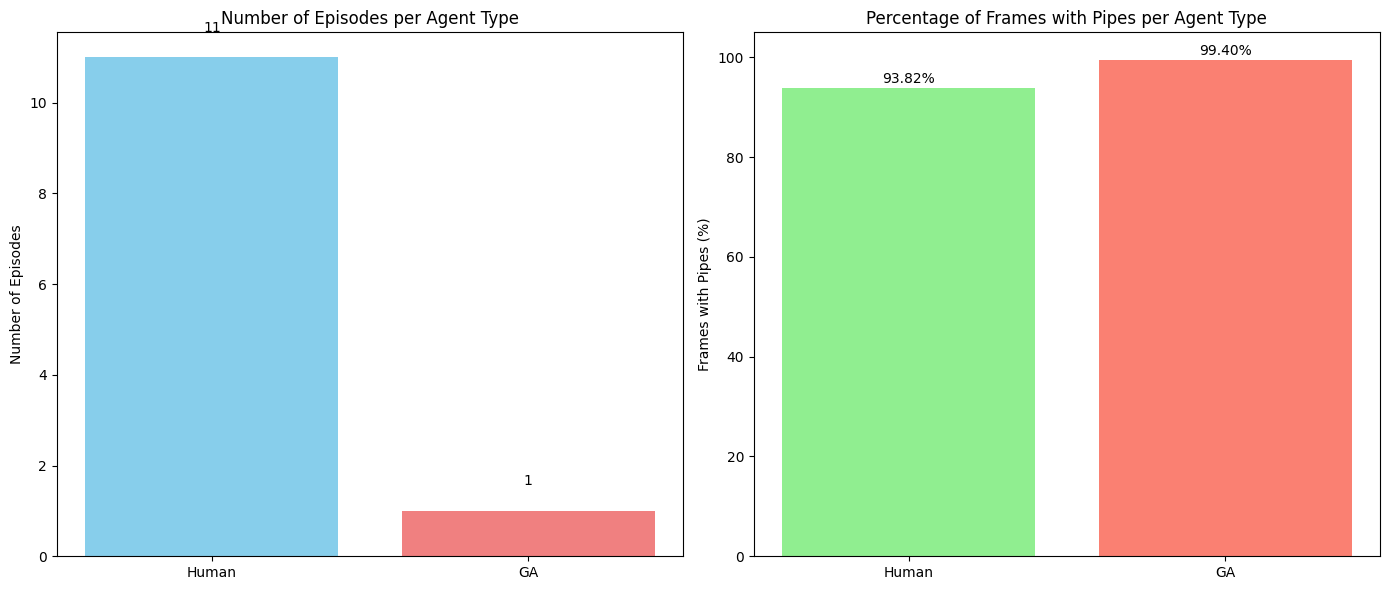

In [ ]:
human_episode_count = human_frames['episode_id'].nunique()
ga_episode_count = ga_frames['episode_id'].nunique()

human_pipe_pct = human_frames['has_pipe_in_frame'].mean() * 100
ga_pipe_pct = ga_frames['has_pipe_in_frame'].mean() * 100

agents = ['Human', 'GA']
episode_counts = [human_episode_count, ga_episode_count]
pipe_percentages = [human_pipe_pct, ga_pipe_pct]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

bars1 = axes[0].bar(agents, episode_counts, color=['skyblue', 'lightcoral'])
axes[0].set_ylabel("Number of Episodes")
axes[0].set_title("Number of Episodes per Agent Type")
axes[0].set_ylim(bottom=0)
for bar in bars1:
  yval = bar.get_height()
  axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval), ha='center', va='bottom')

bars2 = axes[1].bar(agents, pipe_percentages, color=['lightgreen', 'salmon'])
axes[1].set_ylabel("Frames with Pipes (%)")
axes[1].set_title("Percentage of Frames with Pipes per Agent Type")
axes[1].set_ylim(bottom=0, top=105)
for bar in bars2:
  yval = bar.get_height()
  axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


The human gameplay dataset consists of multiple independent episodes, reflecting natural variability, learning effects, and suboptimal decision-making. In contrast, the genetic algorithm (GA) gameplay data represents a single long episode generated by a converged policy optimized for performance.

This asymmetry is intentional and does not represent a methodological flaw. Instead, it allows the analysis to contrast human behavioral variability with algorithmic consistency, particularly at the frame level. All comparative analyses are therefore interpreted in terms of per-frame behavior, control stability, and decision patterns, rather than direct episode-level performance metrics.

=== Action Distribution Comparison (%): ===


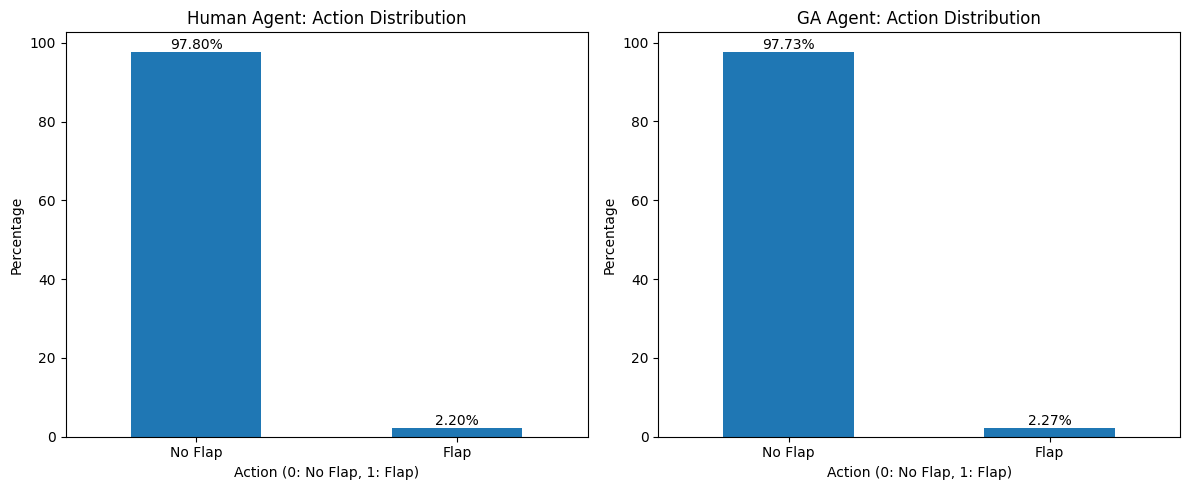

In [ ]:
print("=== Action Distribution Comparison (%): ===")

human_action_counts = human_frames['action'].value_counts(normalize=True).mul(100).round(2)
ga_action_counts = ga_frames['action'].value_counts(normalize=True).mul(100).round(2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax_human = human_action_counts.plot(kind='bar', ax=axes[0])
ax_human.set_title('Human Agent: Action Distribution')
ax_human.set_xlabel('Action (0: No Flap, 1: Flap)')
ax_human.set_ylabel('Percentage')
ax_human.set_xticks([0, 1], ['No Flap', 'Flap'], rotation=0)
for p in ax_human.patches:
  ax_human.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax_ga = ga_action_counts.plot(kind='bar', ax=axes[1])
ax_ga.set_title('GA Agent: Action Distribution')
ax_ga.set_xlabel('Action (0: No Flap, 1: Flap)')
ax_ga.set_ylabel('Percentage')
ax_ga.set_xticks([0, 1], ['No Flap', 'Flap'], rotation=0)
for p in ax_ga.patches:
  ax_ga.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()


The relative frequency of flap actions is similar across human and GA gameplay, suggesting that performance differences are not driven by action frequency alone.

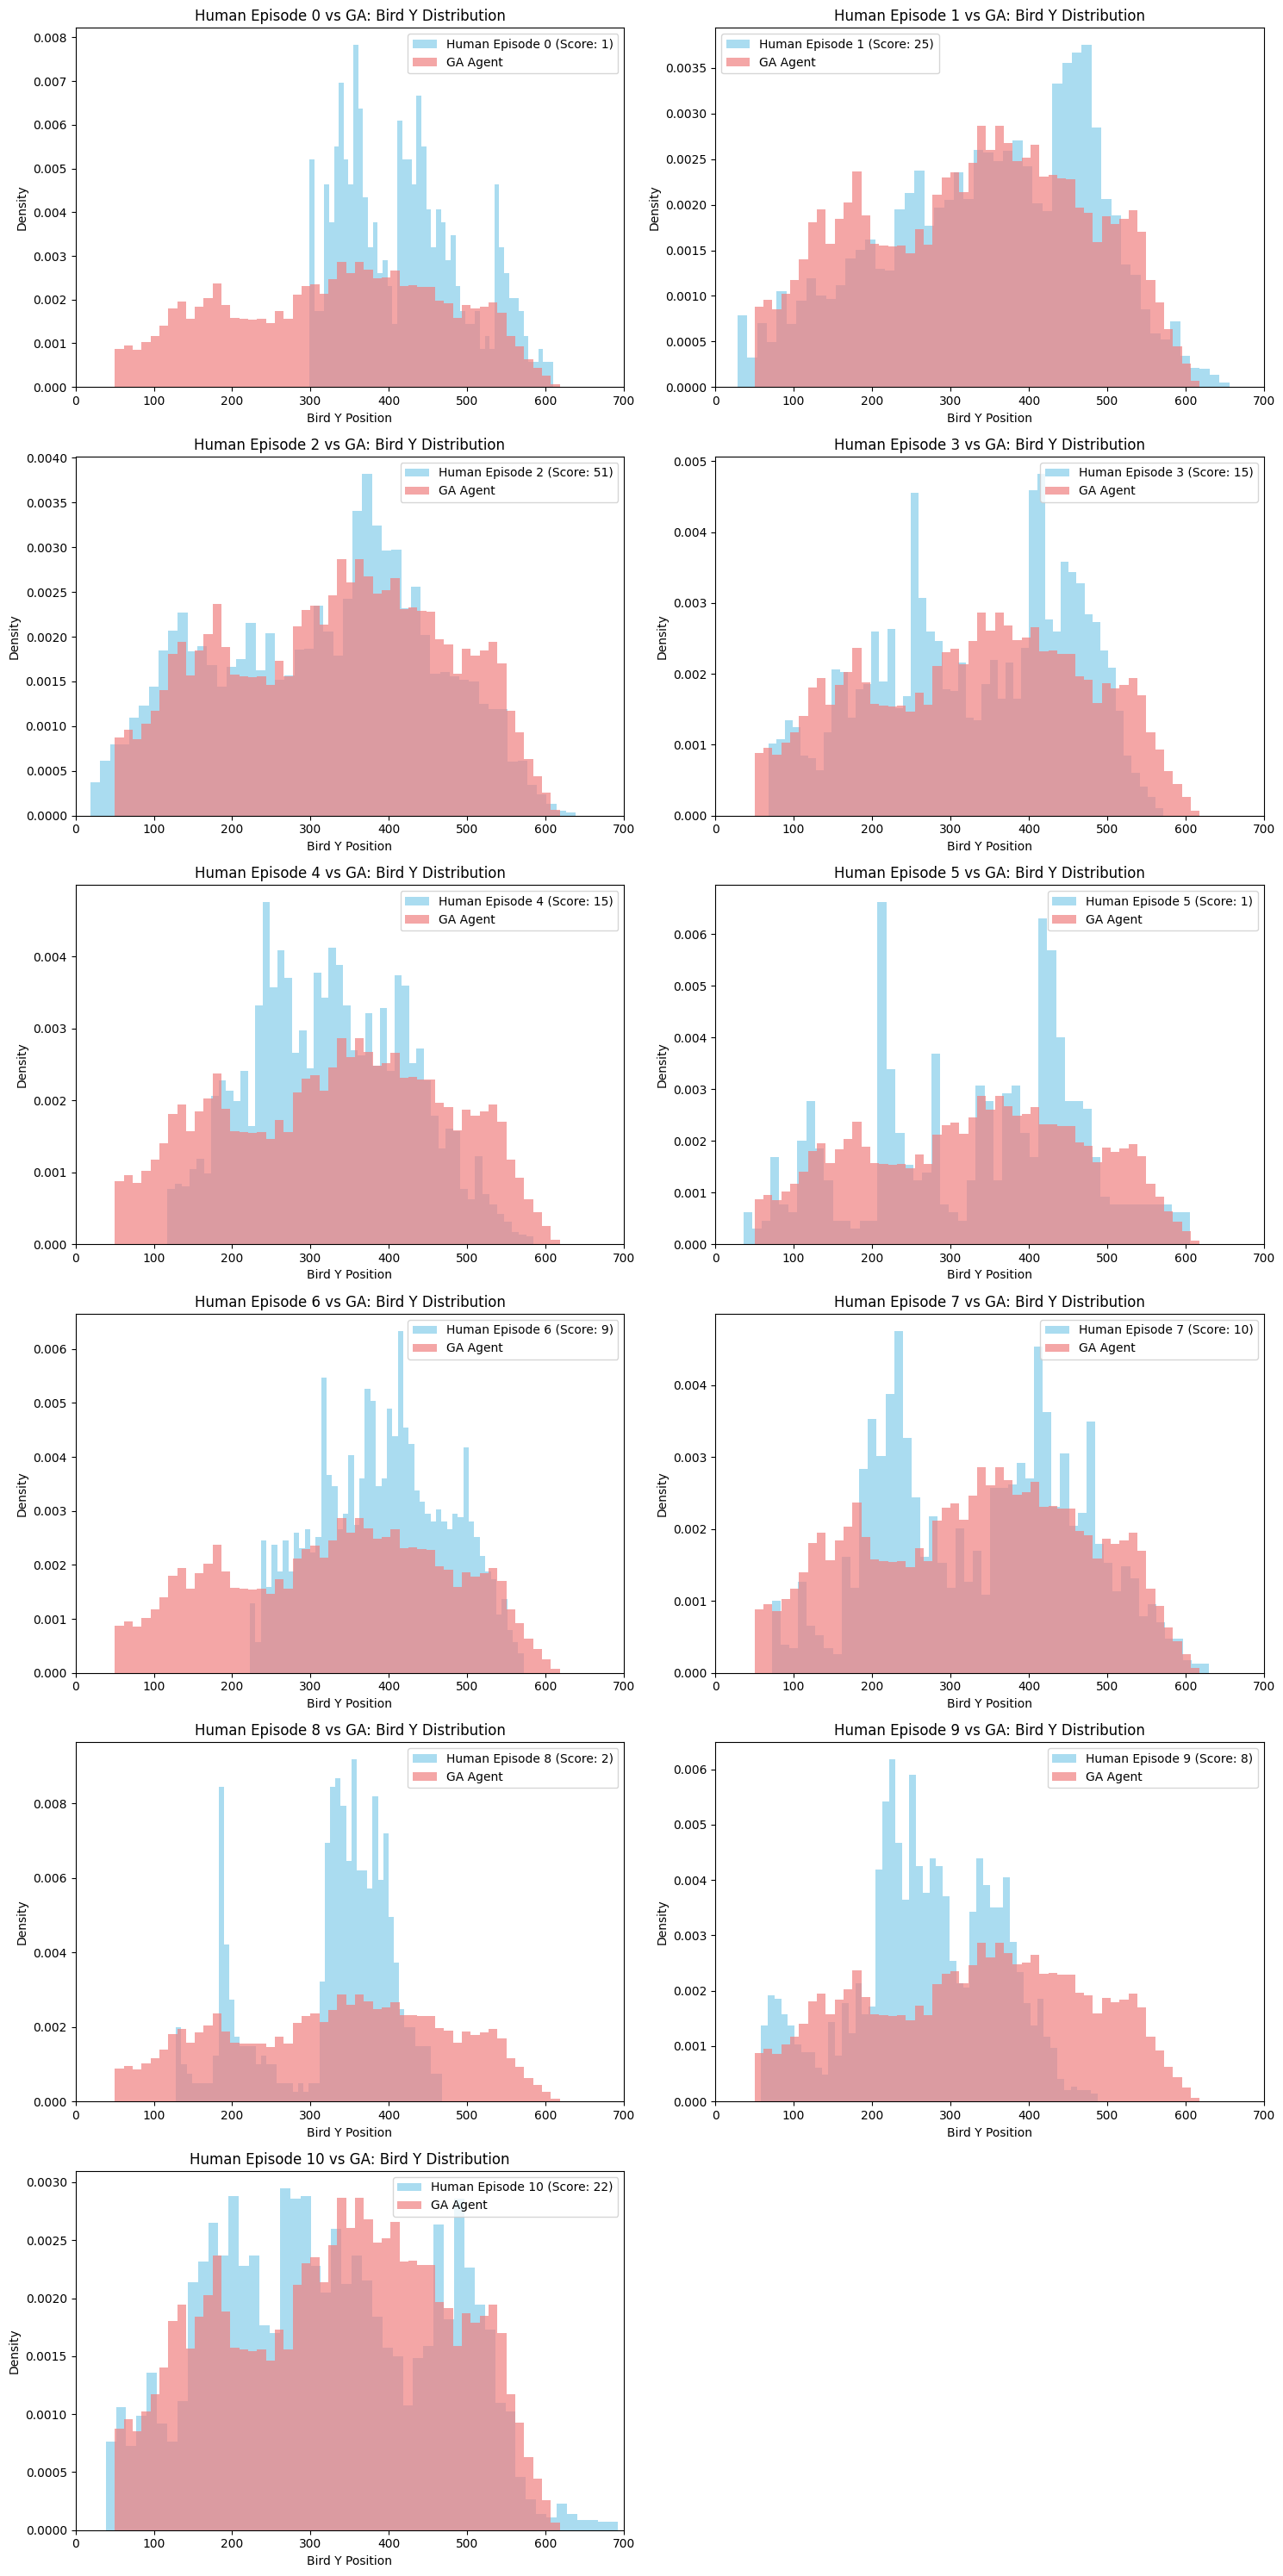

In [ ]:
human_episodes = human_frames['episode_id'].unique()
num_human_episodes = len(human_episodes)

final_human_scores = {}
for episode_id in human_episodes:
  episode_df = human_frames[human_frames['episode_id'] == episode_id]
  final_score = episode_df['score'].max()
  final_human_scores[episode_id] = final_score if pd.notna(final_score) else 0

num_cols = 2
num_rows = (num_human_episodes + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

game_height = human_meta['game_height'].iloc[0]

for i, episode_id in enumerate(human_episodes):
  ax = axes[i]
  human_episode_bird_y = human_frames[human_frames['episode_id'] == episode_id]['bird_y']

  ax.hist(
      human_episode_bird_y,
      bins=50,
      alpha=0.7,
      label=f'Human Episode {episode_id} (Score: {int(final_human_scores.get(episode_id, 0))})',
      density=True,
      color='skyblue'
  )

  ax.hist(
      ga_frames['bird_y'],
      bins=50,
      alpha=0.7,
      label='GA Agent',
      density=True,
      color='lightcoral'
  )
  ax.set_xlim(0, game_height)
  ax.set_title(f'Human Episode {episode_id} vs GA: Bird Y Distribution')
  ax.set_xlabel('Bird Y Position')
  ax.set_ylabel('Density')
  ax.legend()

for j in range(num_human_episodes, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The bird_y distributions highlight clear differences in vertical control strategies between the GA agent and human players. The GA agent consistently maintains the bird within a narrow mid-range of the screen, indicating a stable and optimized strategy that avoids extreme vertical positions. In contrast, human gameplay exhibits substantial variability across episodes: some show broader distributions, while others favor higher or lower vertical regions, reflecting reactive control, recovery attempts, or differing play styles.

Human episodes also display higher densities near the top or bottom of the screen, particularly near episode termination, suggesting less precise control and boundary collisions. Overall, while humans occasionally approximate the GA’s strategy, the GA agent demonstrates more consistent and controlled vertical positioning.

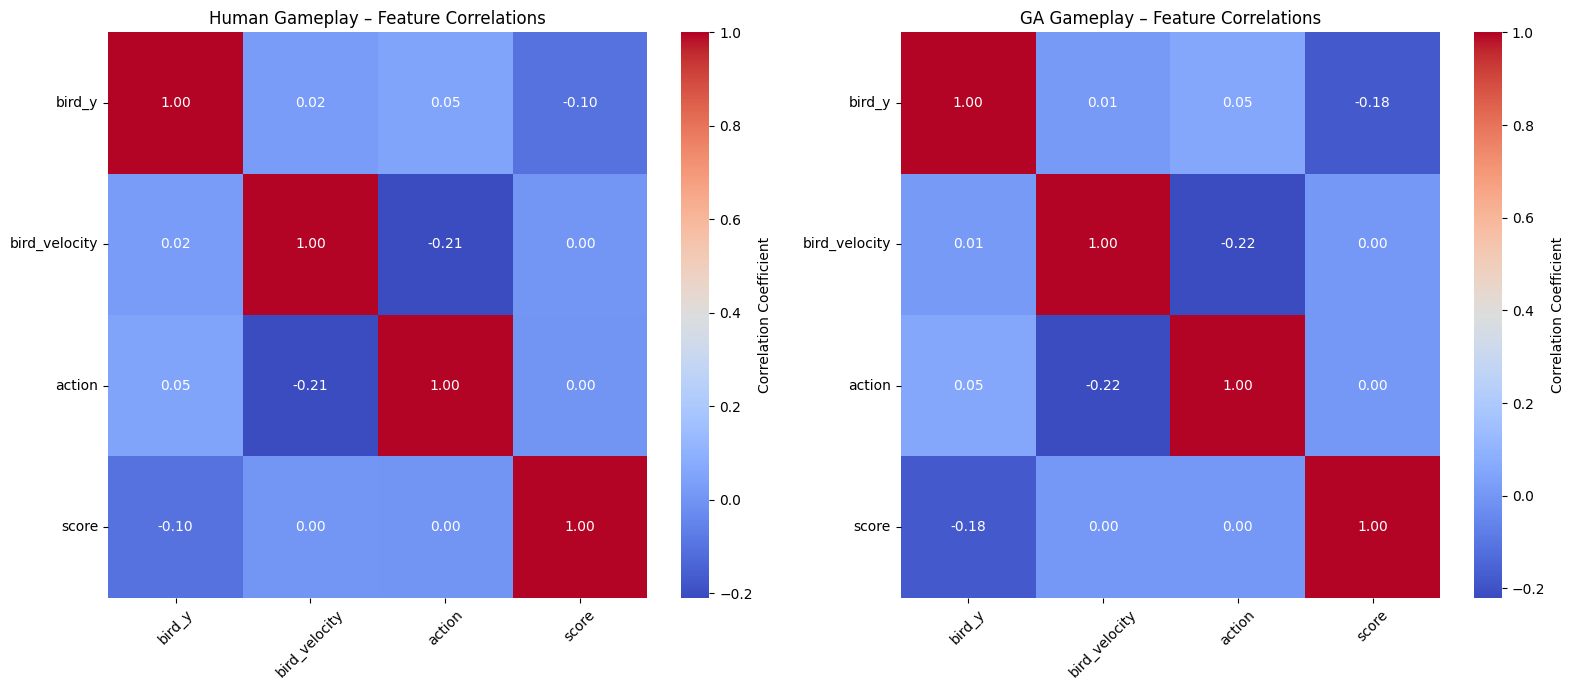

In [ ]:
features_for_correlation = ['bird_y', 'bird_velocity', 'action', 'score']

human_correlation_matrix = human_frames[features_for_correlation].corr()

ga_correlation_matrix = ga_frames[features_for_correlation].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(human_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], cbar_kws={'label': 'Correlation Coefficient'})
axes[0].set_title('Human Gameplay – Feature Correlations')
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

sns.heatmap(ga_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], cbar_kws={'label': 'Correlation Coefficient'})
axes[1].set_title('GA Gameplay – Feature Correlations')
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

The correlation heatmaps show that most frame-level features exhibit weak linear relationships for both human and GA gameplay. For both agents, a consistent negative correlation between action and bird_velocity confirms the expected game mechanic that flapping causes upward movement. The frequency of flapping itself shows virtually no correlation with score, indicating that when actions are taken is more important than how often. Notably, the GA agent displays a slightly stronger negative correlation between bird_y and score than human players, suggesting a more consistent strategy of maintaining the bird in a favorable vertical range, which aligns with its optimized, stable gameplay behavior.

=== Pipe Geometry Summary (Human) ===


,pipe_x,pipe_top_y,pipe_bot_y
count,56211.000000,56211.000000,56211.000000
mean,217.889700,253.886593,453.886593
std,165.550533,136.369805,136.369805
min,-74.480000,1.109378,201.109378
25%,75.820000,150.273108,350.273108
50%,221.110000,248.668971,448.668971
75%,361.390000,375.191976,575.191976
max,498.330000,493.558706,693.558706



=== Pipe Geometry Summary (GA) ===


,pipe_x,pipe_top_y,pipe_bot_y
count,56999.000000,56999.000000,56999.000000
mean,212.551950,262.627965,462.627965
std,165.584955,146.392528,146.392528
min,-74.480000,2.297008,202.297008
25%,69.140000,126.690734,326.690734
50%,212.760000,278.755524,478.755524
75%,356.380000,386.820894,586.820894
max,498.330000,496.978263,696.978263


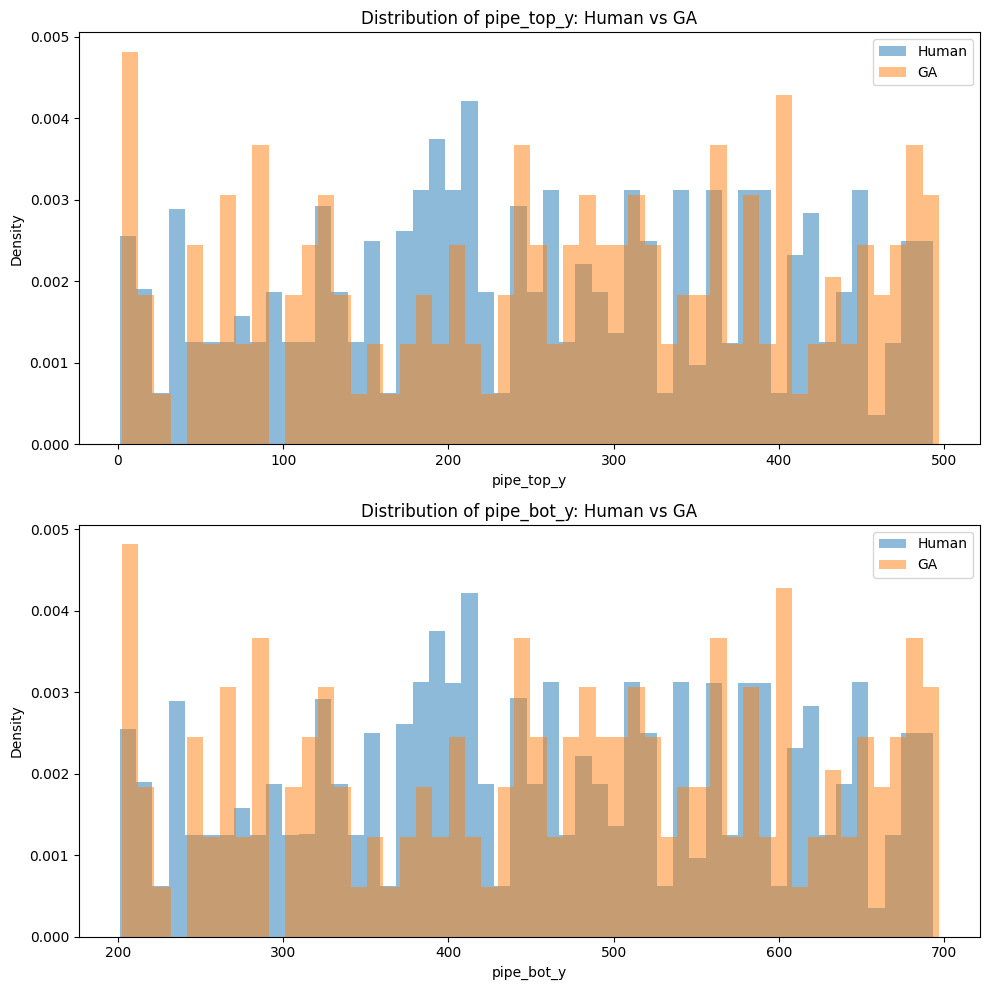

In [ ]:
pipe_df = pd.read_csv(
    os.path.join("cleaned_data", "all_pipe_data_normalized.csv")
)

human_pipes = pipe_df[pipe_df['agent_type'] == 'human']
ga_pipes = pipe_df[pipe_df['agent_type'] == 'ga']

print("=== Pipe Geometry Summary (Human) ===")
display(human_pipes[['pipe_x', 'pipe_top_y', 'pipe_bot_y']].describe())

print("\n=== Pipe Geometry Summary (GA) ===")
display(ga_pipes[['pipe_x', 'pipe_top_y', 'pipe_bot_y']].describe())

features = ['pipe_top_y', 'pipe_bot_y']

fig, axes = plt.subplots(len(features), 1, figsize=(10, 5 * len(features)))
axes = axes.flatten()

for i, feature in enumerate(features):
  ax = axes[i]
  ax.hist(human_pipes[feature], bins=50, alpha=0.5, label='Human', density=True)
  ax.hist(ga_pipes[feature], bins=50, alpha=0.5, label='GA', density=True)
  ax.set_xlabel(feature)
  ax.set_ylabel("Density")
  ax.set_title(f"Distribution of {feature}: Human vs GA")
  ax.legend()

plt.tight_layout()
plt.show()

Pipe placement and geometry are environment-driven and independent of agent behavior. Observed performance differences therefore arise from agent control strategies rather than level design bias.

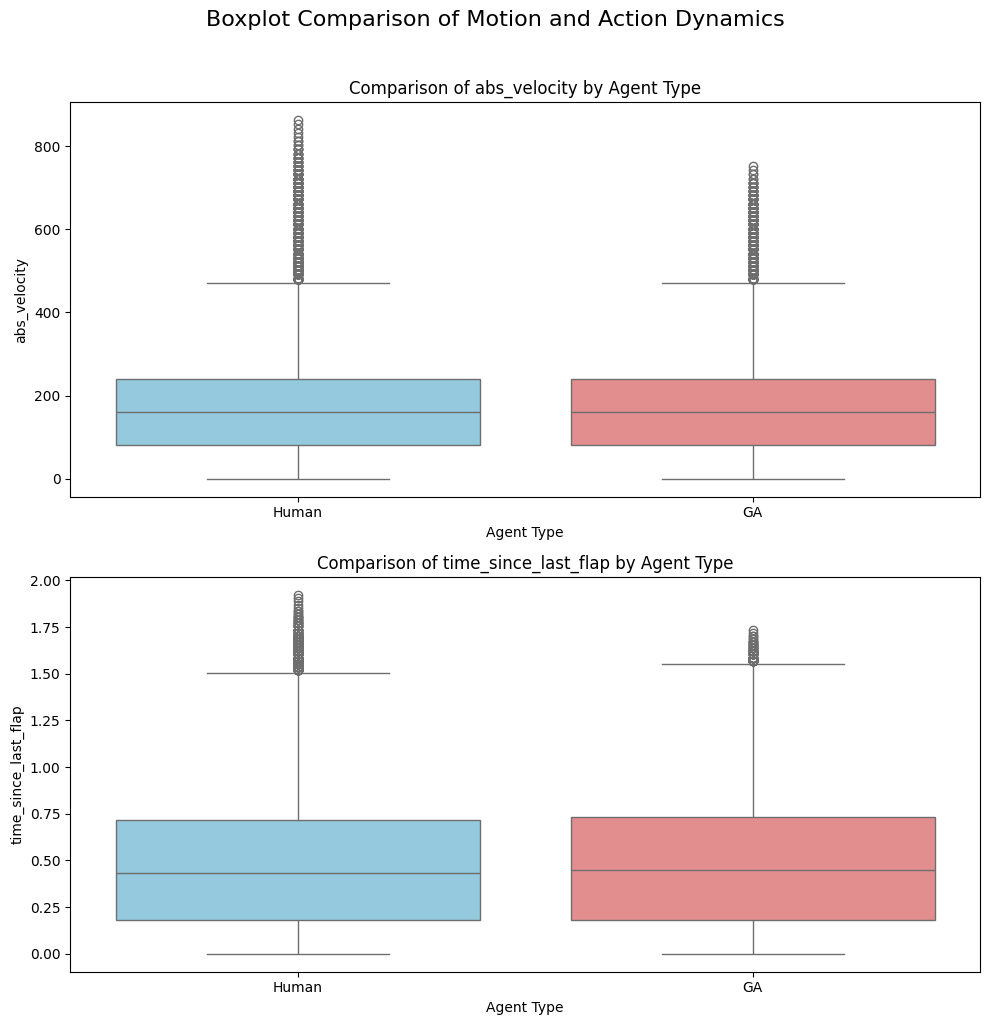

In [ ]:
features_to_analyze = [
    'abs_velocity',
    'time_since_last_flap'
]

fig, axes = plt.subplots(len(features_to_analyze), 1, figsize=(10, 5 * len(features_to_analyze)))
fig.suptitle('Boxplot Comparison of Motion and Action Dynamics', y=1.02, fontsize=16)

for i, feature in enumerate(features_to_analyze):
  data_human = human_frames_features[feature].dropna()
  data_ga = ga_frames_features[feature].dropna()

  combined_data = pd.DataFrame({
      feature: pd.concat([data_human, data_ga]),
      'Agent Type': ['Human'] * len(data_human) + ['GA'] * len(data_ga)
  })

  sns.boxplot(x='Agent Type', y=feature, data=combined_data, ax=axes[i], palette={'Human': 'skyblue', 'GA': 'lightcoral'}, hue='Agent Type', legend=False)
  axes[i].set_title(f'Comparison of {feature} by Agent Type')
  axes[i].set_xlabel('Agent Type')
  axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

Although fairly similar, the wider spread outliers cover on the "absolute velocity" and "time since last flap" boxplots signifies more erratic and less refined behaviour from the human agents.

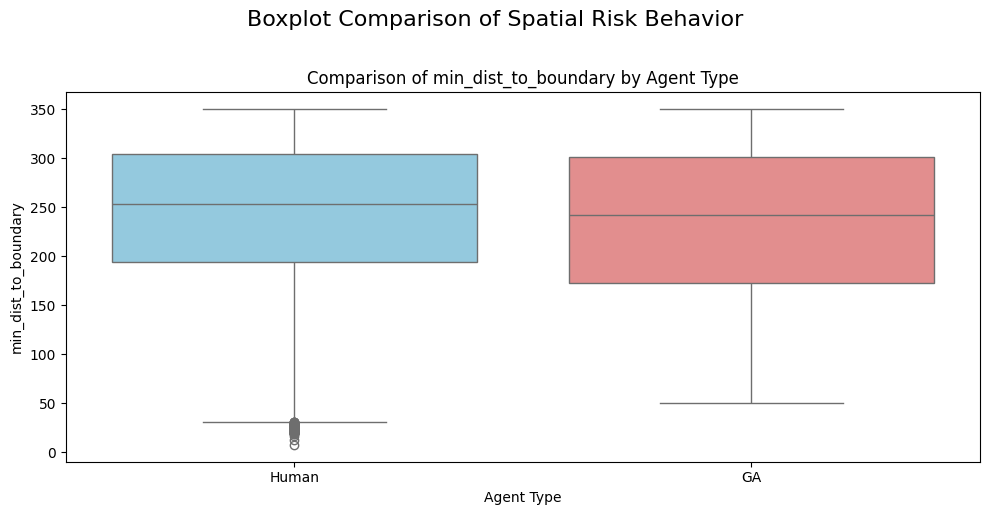

In [ ]:
features_to_analyze = [
    'min_dist_to_boundary',
]

fig, axes = plt.subplots(len(features_to_analyze), 1, figsize=(10, 5 * len(features_to_analyze)))
fig.suptitle('Boxplot Comparison of Spatial Risk Behavior', y=1.02, fontsize=16)

if len(features_to_analyze) == 1:
  axes = [axes]

for i, feature in enumerate(features_to_analyze):
  data_human = human_frames_features[feature].dropna()
  data_ga = ga_frames_features[feature].dropna()

  combined_data = pd.DataFrame({
      feature: pd.concat([data_human, data_ga]),
      'Agent Type': ['Human'] * len(data_human) + ['GA'] * len(data_ga)
  })

  sns.boxplot(x='Agent Type', y=feature, data=combined_data, ax=axes[i], palette={'Human': 'skyblue', 'GA': 'lightcoral'}, hue='Agent Type', legend=False)
  axes[i].set_title(f'Comparison of {feature} by Agent Type')
  axes[i].set_xlabel('Agent Type')
  axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

Although the interquartile range (IQR) is larger in case of the GA agent (the amount of time spent closer to the upper/lower boundary varies a more significant amount), the human agent nonetheless shows (just the same as in the previous boxplot) more error-prone behaviour, frames spent much closer to the boundaries represented as outliers.

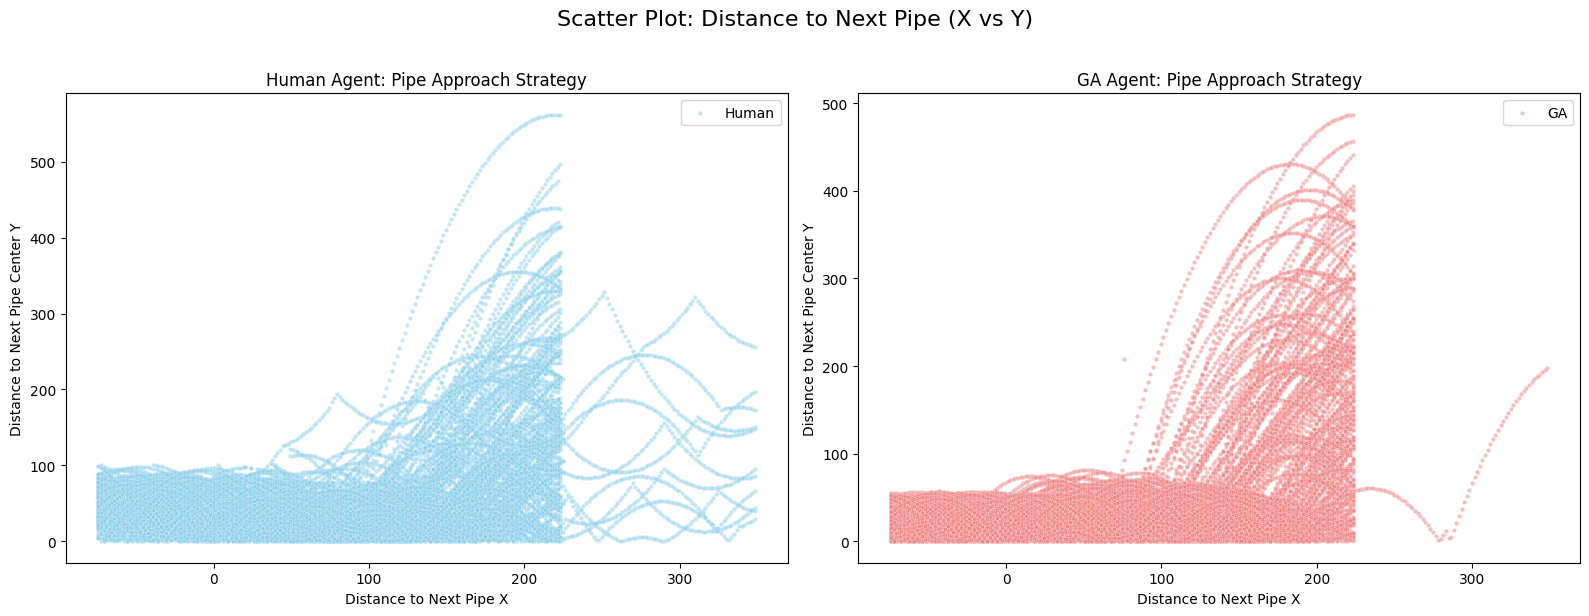

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Scatter Plot: Distance to Next Pipe (X vs Y)', y=1.02, fontsize=16)

sns.scatterplot(
    x='dist_to_next_pipe_x',
    y='dist_to_next_pipe_center_y',
    data=human_frames_features.dropna(subset=['dist_to_next_pipe_x', 'dist_to_next_pipe_center_y']),
    ax=axes[0],
    color='skyblue',
    alpha=0.5,
    s=10
)
axes[0].set_title('Human Agent: Pipe Approach Strategy')
axes[0].set_xlabel('Distance to Next Pipe X')
axes[0].set_ylabel('Distance to Next Pipe Center Y')
axes[0].legend(labels=['Human'])

sns.scatterplot(
    x='dist_to_next_pipe_x',
    y='dist_to_next_pipe_center_y',
    data=ga_frames_features.dropna(subset=['dist_to_next_pipe_x', 'dist_to_next_pipe_center_y']),
    ax=axes[1],
    color='lightcoral',
    alpha=0.5,
    s=10
)
axes[1].set_title('GA Agent: Pipe Approach Strategy')
axes[1].set_xlabel('Distance to Next Pipe X')
axes[1].set_ylabel('Distance to Next Pipe Center Y')
axes[1].legend(labels=['GA'])

plt.tight_layout()
plt.show()

The above plot shows the GA agent's "method" for approaching a pipe is more controlled, whereas a human's approach tends to be more "chaotic." This further solidifies the fact a GA agent iteratively shows greater improvement over evolutions considering the episode for which the above plot is true could be considered "near-optimal".

### Statistical comparison of human vs. GA gameplay

#### Hypotheses Formulation
**$H_0$: The distributions of the selected feature for human and GA gameplay are identical.**

**$H_1$: The distributions of the selected feature for human and GA gameplay differ significantly.**

#### Kolmogorov-Smirnov (KS) Test

The Kolmogorov-Smirnov test is used to compare the full distributions of continuous variables without assuming any specific underlying distribution. This makes it well-suited for gameplay data, which may be non-normal and highly dynamic. A low p-value (typically < 0.05) indicates a significant difference between the distributions, leading to the rejection of the null hypothesis.

In [ ]:
features_to_test = [
    'abs_velocity',
    'time_since_last_flap',
    'dist_to_next_pipe_center_y',
    'min_dist_to_boundary',
    'dist_to_next_pipe_x'
]

results = {}
for feature in features_to_test:
  data_human = human_frames_features[feature].dropna().to_numpy()
  data_ga = ga_frames_features[feature].dropna().to_numpy()

  if len(data_human) == 0 or len(data_ga) == 0:
    print(f"Skipping {feature}: Not enough data after dropping NaNs.")
    continue

  statistic, p_value = stats.ks_2samp(data_human, data_ga)

  results[feature] = {'statistic': statistic, 'p_value': p_value}

  print(f"Feature: {feature}")
  print(f"KS Statistic: {statistic:.4f}")
  print(f"P-value: {p_value:.4f}")

Feature: abs_velocity
KS Statistic: 0.0161
P-value: 0.0006
Feature: time_since_last_flap
KS Statistic: 0.0186
P-value: 0.0000
Feature: dist_to_next_pipe_center_y
KS Statistic: 0.2203
P-value: 0.0000
Feature: min_dist_to_boundary
KS Statistic: 0.0900
P-value: 0.0000
Feature: dist_to_next_pipe_x
KS Statistic: 0.0251
P-value: 0.0000


Although the Kolmogorov-Smirnov test is indicating statistically significant differences (p-value is < 0.05, which should throw out $H_0$), this will not be prioritized due to the high number of data points. Therefore, the KS statistic magnitude is emphasized over p-values when assessing practical significance. However, since the KS statistic is close to 0, the observed distributions are very similar in practice. However, the plots explored in the EDA reveal consistent differences in "data spread". This indicates that while human and GA behaviors overlap substantially, they are not identical and differ in subtle but meaningful ways.

### Applying machine learning (ML) to the problem


#### Applying KMeans clustering

In [ ]:
engineered_features = [
    'abs_velocity',
    'time_since_last_flap',
    'min_dist_to_boundary',
    'dist_to_next_pipe_x',
    'dist_to_next_pipe_center_y'
]

human_frames_features = pd.read_csv(os.path.join(features_output_dir, "human_frames_features.csv"))
ga_frames_features = pd.read_csv(os.path.join(features_output_dir, "ga_frames_features.csv"))

human_data_for_clustering = human_frames_features.copy()
human_data_for_clustering['agent_type'] = 'human'

ga_data_for_clustering = ga_frames_features.copy()
ga_data_for_clustering['agent_type'] = 'ga'

combined_data = pd.concat([human_data_for_clustering, ga_data_for_clustering], ignore_index=True)

features_for_clustering = combined_data[engineered_features + ['agent_type']].copy()

initial_rows = features_for_clustering.shape[0]
features_for_clustering.dropna(subset=engineered_features, inplace=True)
rows_after_dropna = features_for_clustering.shape[0]

print(f"Initial rows: {initial_rows}")
print(f"Rows after dropping NaNs: {rows_after_dropna}")
print(f"Dropped {initial_rows - rows_after_dropna} rows due to NaN values in engineered features.")

print("\nHead of the prepared data for clustering:")
display(features_for_clustering.head())

print("\nInfo of the prepared data for clustering:")
features_for_clustering.info()


Initial rows: 62211
Rows after dropping NaNs: 60041
Dropped 2170 rows due to NaN values in engineered features.

Head of the prepared data for clustering:


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y,agent_type
180,110.82,0.6680,309.866814,348.33,196.824328,human
181,120.84,0.6847,311.884842,346.66,194.806300,human
182,130.86,0.7014,314.070204,344.99,192.620938,human
183,140.88,0.7181,316.422900,343.32,190.268242,human
184,150.90,0.7348,318.942930,341.65,187.748212,human



Info of the prepared data for clustering:
<class 'pandas.core.frame.DataFrame'>
Index: 60041 entries, 180 to 62210
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   abs_velocity                60041 non-null  float64
 1   time_since_last_flap        60041 non-null  float64
 2   min_dist_to_boundary        60041 non-null  float64
 3   dist_to_next_pipe_x         60041 non-null  float64
 4   dist_to_next_pipe_center_y  60041 non-null  float64
 5   agent_type                  60041 non-null  object 
dtypes: float64(5), object(1)
memory usage: 3.2+ MB


Frames containing NaN values in engineered features were removed prior to clustering. These NaNs occur in frames where no upcoming pipe exists (at the beginning of an episode, as was mentioned previously), making distance-based pipe features undefined. Since the analysis focuses on agent behaviour during pipe interaction, removing these frames is appropriate and does not introduce bias.

In [ ]:
engineered_features = [
    'abs_velocity',
    'time_since_last_flap',
    'min_dist_to_boundary',
    'dist_to_next_pipe_x',
    'dist_to_next_pipe_center_y'
]

X_for_clustering = features_for_clustering[engineered_features].copy()
y_agent_type = features_for_clustering['agent_type'].copy()

scaler_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

X_scaled_array = scaler_pipeline.fit_transform(X_for_clustering)

X_scaled = pd.DataFrame(X_scaled_array, columns=engineered_features)

print("\nHead of the scaled data (X_scaled):")
display(X_scaled.head())

print("\nDescriptive statistics of the scaled data:")
display(X_scaled.describe())


Head of the scaled data (X_scaled):


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y
0,-0.519662,0.545210,0.971564,3.028139,1.953785
1,-0.431512,0.594192,0.998192,3.009404,1.924680
2,-0.343362,0.643174,1.027028,2.990669,1.893163
3,-0.255213,0.692155,1.058072,2.971933,1.859231
4,-0.167063,0.741137,1.091324,2.953198,1.822887



Descriptive statistics of the scaled data:


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y
count,6.004100e+04,6.004100e+04,6.004100e+04,6.004100e+04,6.004100e+04
mean,2.556207e-17,-3.715968e-17,5.429573e-16,5.562117e-17,2.792893e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.489309e+00,-1.414056e+00,-3.015968e+00,-1.711926e+00,-8.848565e-01
25%,-7.841109e-01,-8.752576e-01,-7.416515e-01,-8.500960e-01,-5.936236e-01
50%,-7.891332e-02,-9.155109e-02,1.237949e-01,-7.001332e-03,-2.568141e-01
75%,6.157275e-01,6.921554e-01,8.520957e-01,8.360933e-01,7.966064e-02
max,6.091566e+00,4.218835e+00,1.501121e+00,3.028139e+00,7.217076e+00


The engineered features were standardized using z-score normalization prior to modeling. As shown by the descriptive statistics of the scaled data, all features exhibit means approximately equal to zero and standard deviations close to one, confirming that the scaling procedure was applied correctly. This normalization ensures that each feature contributes equally during the following modeling and prevents features with larger numeric ranges from disproportionately influencing distance-based or linear models. The presence of both positive and negative standardized values reflects relative deviations from the dataset mean, while the observed minimum and maximum values indicate the extent of rare or extreme gameplay states. Overall, the scaled feature distributions are well-conditioned for subsequent clustering and classification analyses.

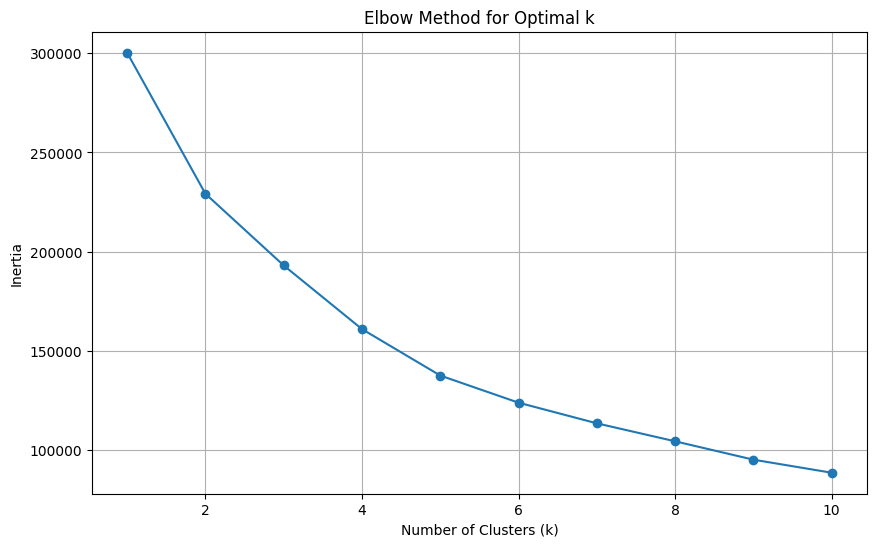

Inertia values calculated for k from 1 to 10.


In [ ]:
inertia_values = []

k_range = range(1, 11)

for k in k_range:
  kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')
  kmeans_model.fit(X_scaled)
  inertia_values.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o', linestyle='-')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

print("Inertia values calculated for k from 1 to 10.")

Based on the Elbow Method plot, the elbow point appears to be around k=3 or k=4, although this is approximated with a certain degree of uncertainty as the curve visible on the plot is relatively "smooth". This already suggests the absence of strong, naturally separable clusters in the feature space, indicating that human and GA gameplay behaviors form overlapping, continuous distributions rather than distinct groups. Nonetheless, after this point, the decrease in inertia slowly starts to level off, mildly indicating diminishing returns for adding more clusters. This suggests that 3 or 4 clusters might provide a good balance between capturing the data's structure and avoiding overfitting.

For the subsequent steps, k=3 will be chosen as the optimal number of clusters, as it's the point where the curve clearly starts to bend significantly.

In [ ]:
optimal_k = 3

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels = kmeans_optimal.fit_predict(X_scaled)
features_for_clustering['cluster'] = cluster_labels

print(f"K-Means clustering applied with k={optimal_k}.")
print("Head of features_for_clustering with new 'cluster' column:")
display(features_for_clustering.head())

print("Cluster distribution:")
display(features_for_clustering['cluster'].value_counts().sort_index())

K-Means clustering applied with k=3.
Head of features_for_clustering with new 'cluster' column:


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y,agent_type,cluster
180,110.82,0.6680,309.866814,348.33,196.824328,human,2
181,120.84,0.6847,311.884842,346.66,194.806300,human,2
182,130.86,0.7014,314.070204,344.99,192.620938,human,2
183,140.88,0.7181,316.422900,343.32,190.268242,human,2
184,150.90,0.7348,318.942930,341.65,187.748212,human,2


Cluster distribution:


,count
cluster,
0,28712
1,21190
2,10139


K-Means clustering with k=3 grouped frames into common gameplay states rather than separating human and GA agents, with clusters dominated by frequent behavioral patterns and substantial overlap between agent types. The clusters are showing relatively strong imbalance.

In [ ]:
cluster_agent_counts = features_for_clustering.groupby(['cluster', 'agent_type']).size().unstack(fill_value=0)

print("Count of agent types within each cluster:")
display(cluster_agent_counts)

Count of agent types within each cluster:


agent_type,ga,human
cluster,,
0,13818,14894
1,11376,9814
2,4626,5513


In [ ]:
cluster_agent_percentages = cluster_agent_counts.apply(lambda x: x / x.sum() * 100, axis=1)

print("Percentage of agent types within each cluster:")
display(cluster_agent_percentages)

Percentage of agent types within each cluster:


agent_type,ga,human
cluster,,
0,48.126219,51.873781
1,53.685701,46.314299
2,45.625801,54.374199


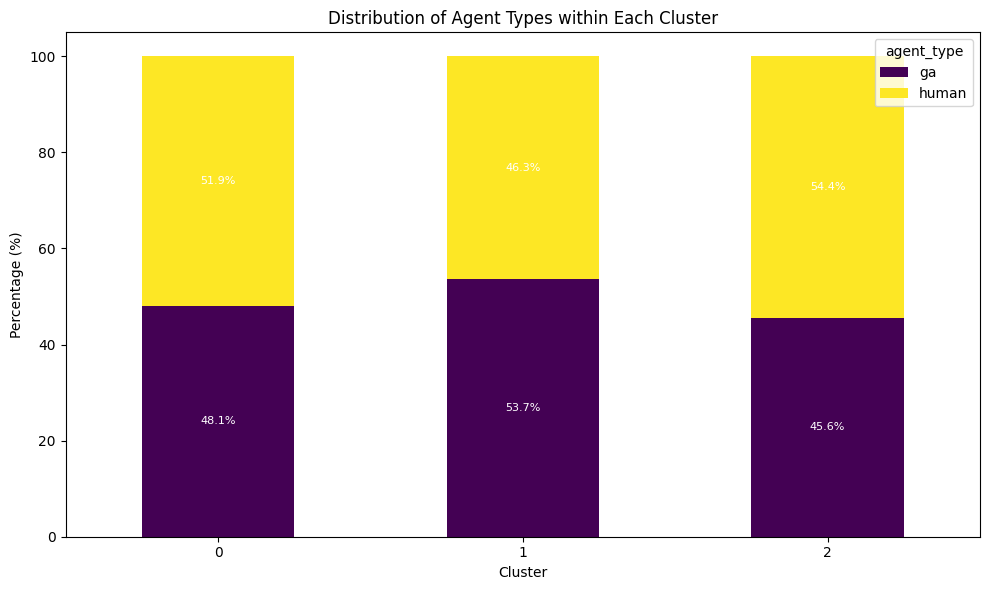

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

cluster_agent_percentages.plot(kind='bar', stacked=True, ax=ax, cmap='viridis')

ax.set_title('Distribution of Agent Types within Each Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(range(len(cluster_agent_percentages.index)))
ax.set_xticklabels(cluster_agent_percentages.index, rotation=0)

for container in ax.containers:
  labels = [f'{w:.1f}%' if (w := v.get_height()) > 0 else '' for v in container]
  ax.bar_label(container, labels=labels, label_type='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()

The analysis of cluster occupancy reveals distinct behavioral patterns between human and GA agents:

* **Cluster 0**: This cluster shows a near even split between human (51.9%) and GA (48.1%) agents. This suggests that this cluster represents a common behavioral mode that both human players and the GA agent frequently exhibit.

* **Cluster 1**: The GA agent dominates this cluster with 53.7% of its data points, compared to 46.3% for human agents. This indicates that Cluster 1 likely captures a behavior that is more characteristic or preferred by the optimized GA agent.

* **Cluster 2**: Human agents slightly outnumber GA agents in this cluster, with 54.4% of data points belonging to humans and 45.6% to the GA. This cluster might represent behaviors that are more common among human players or specific phases of human gameplay.

Overall, while there is a significant overlap in the behaviors exhibited by both agent types across the clusters, each cluster shows a very slight, but possibly significant, preference for one agent over the other. This suggests that while both agents share fundamental gameplay mechanics, their strategies lead to subtly different distributions within the discovered behavioral groups.

However, as it stands, the "nearly equal" distribution of human and GA frames within each cluster demonstrates that K-Means clustering captures common gameplay states rather than distinguishing between agent types.

In [ ]:
cluster_means = features_for_clustering.groupby('cluster')[engineered_features].mean()

print("Mean values of engineered features per cluster (using original unscaled data):")
display(cluster_means)

Mean values of engineered features per cluster (using original unscaled data):


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y
cluster,,,,,
0,148.170481,0.390700,288.60125,75.244402,42.196481
1,141.723245,0.458959,161.66524,32.655866,36.167213
2,290.263827,0.789375,243.79304,183.022401,168.248302


Analysis of mean engineered feature values reveals three distinct gameplay states shared by both human and GA agents:

* **Cluster 0 - Controlled Passage**:
Characterized by moderate velocity, frequent but controlled flapping, large distances from screen boundaries, and reasonable alignment with upcoming pipes. This cluster represents stable, safe gameplay and corresponds to efficient pipe navigation.

* **Cluster 1 - Close-Call Navigation**:
Defined by reduced distance to boundaries and pipes, but strong vertical alignment with pipe centers. This reflects high-risk, reactive gameplay during tight situations or near-collisions, suggesting more aggressive decision-making.

* **Cluster 2 - Erratic / Rebalancing Movement**:
Marked by high absolute velocity, infrequent flapping, poor pipe alignment, and large horizontal distance from the next pipe. This cluster captures unstable or corrective gameplay phases, often occurring after mistakes or at transitional moments.

Overall, as was mentioned previously, the clusters seem to describe gameplay states rather than agent identities, reinforcing the conclusion that both humans and the GA occupy similar behavioral patterns, even if they transition between them differently.

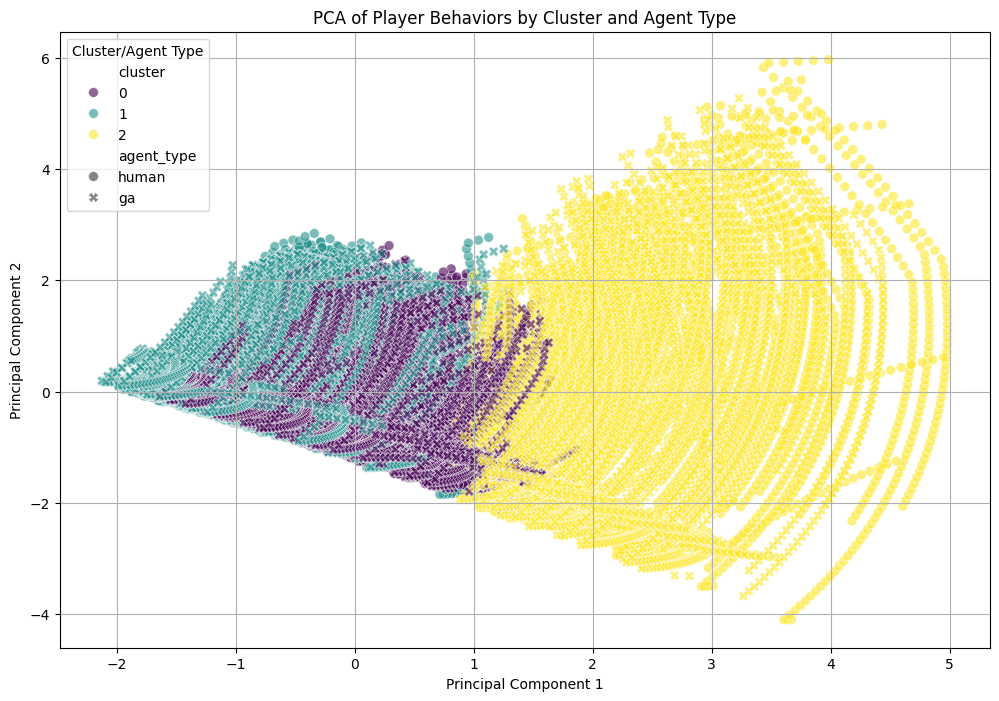

In [ ]:
pca = PCA(n_components=2, random_state=42)

pca_components = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=pca_components, columns=['Principal Component 1', 'Principal Component 2'])

pca_df['cluster'] = features_for_clustering['cluster'].reset_index(drop=True)
pca_df['agent_type'] = y_agent_type.reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Principal Component 1',
    y='Principal Component 2',
    hue='cluster',
    style='agent_type',
    data=pca_df,
    palette='viridis',
    alpha=0.6,
    s=50
)

plt.title('PCA of Player Behaviors by Cluster and Agent Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Cluster/Agent Type')
plt.show()

The above plot shows K-Means clusters (colors) in a space of reduced dimensions for visualization purposes. It llustrates distinct but overlapping gameplay states. Human and GA frames (markers) largely occupy the same regions, which (as previously mentioned when discussing the "raw numbers" alone) indicates shared behavioral patterns rather than agent-specific separation.

Unsuprinsingly so, overall, clustering could not give much insight into differentiating between agents when given previously provided data. To achieve this goal, supervised learning binary classification models will be used.

#### Applying Logistic Regression

In [ ]:
engineered_features_sl = [
    'abs_velocity',
    'time_since_last_flap',
    'min_dist_to_boundary',
    'dist_to_next_pipe_x',
    'dist_to_next_pipe_center_y'
]

human_frames_features_sl = pd.read_csv(os.path.join(features_output_dir, "human_frames_features.csv"))
ga_frames_features_sl = pd.read_csv(os.path.join(features_output_dir, "ga_frames_features.csv"))

human_data_sl = human_frames_features_sl.copy()
human_data_sl['agent_label'] = 0

ga_data_sl = ga_frames_features_sl.copy()
ga_data_sl['agent_label'] = 1

combined_data_sl = pd.concat([human_data_sl, ga_data_sl], ignore_index=True)

features_for_sl = combined_data_sl[engineered_features_sl + ['agent_label']].copy()

initial_rows_sl = features_for_sl.shape[0]
features_for_sl.dropna(subset=engineered_features_sl, inplace=True)
rows_after_dropna_sl = features_for_sl.shape[0]

print(f"Initial rows: {initial_rows_sl}")
print(f"Rows after dropping NaNs: {rows_after_dropna_sl}")
print(f"Dropped {initial_rows_sl - rows_after_dropna_sl} rows due to NaN values in engineered features.")

print("\nHead of the prepared data for supervised learning:")
display(features_for_sl.head())

print("\nInfo of the prepared data for supervised learning:")
features_for_sl.info()

Initial rows: 62211
Rows after dropping NaNs: 60041
Dropped 2170 rows due to NaN values in engineered features.

Head of the prepared data for supervised learning:


,abs_velocity,time_since_last_flap,min_dist_to_boundary,dist_to_next_pipe_x,dist_to_next_pipe_center_y,agent_label
180,110.82,0.6680,309.866814,348.33,196.824328,0
181,120.84,0.6847,311.884842,346.66,194.806300,0
182,130.86,0.7014,314.070204,344.99,192.620938,0
183,140.88,0.7181,316.422900,343.32,190.268242,0
184,150.90,0.7348,318.942930,341.65,187.748212,0



Info of the prepared data for supervised learning:
<class 'pandas.core.frame.DataFrame'>
Index: 60041 entries, 180 to 62210
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   abs_velocity                60041 non-null  float64
 1   time_since_last_flap        60041 non-null  float64
 2   min_dist_to_boundary        60041 non-null  float64
 3   dist_to_next_pipe_x         60041 non-null  float64
 4   dist_to_next_pipe_center_y  60041 non-null  float64
 5   agent_label                 60041 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 3.2 MB


Much like what was done when using KMeans, the final dataset here(after running the previous cell) includes five engineered numerical features and a binary target label (agent_label, where 0 = human and 1 = GA). All features are continuous, with no remaining missing values, making the data suitable for supervised binary classification.

The engineered features were explicitly designed to reflect decision-making and control strategies. This is specifically why they were used as "inputs" for both models.

In [ ]:
X = features_for_sl.drop(columns=['agent_label'])
y = features_for_sl['agent_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes of the datasets after train-test split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nDistribution of agent_label in original data:")
display(y.value_counts(normalize=True))

print("\nDistribution of agent_label in training set:")
display(y_train.value_counts(normalize=True))

print("\nDistribution of agent_label in testing set:")
display(y_test.value_counts(normalize=True))

Shapes of the datasets after train-test split:
X_train shape: (48032, 5)
X_test shape: (12009, 5)
y_train shape: (48032,)
y_test shape: (12009,)

Distribution of agent_label in original data:


,proportion
agent_label,
0,0.503339
1,0.496661



Distribution of agent_label in training set:


,proportion
agent_label,
0,0.503331
1,0.496669



Distribution of agent_label in testing set:


,proportion
agent_label,
0,0.503372
1,0.496628


The dataset was split into training (80%) and testing (20%) sets, resulting in 48,032 training samples and 12,009 testing samples, each with 5 engineered features.
The distribution of agent_label remains nearly identical across the original, training, and testing datasets (≈50% human, ≈50% GA), indicating that the split preserved class balance.

This ensures that the model is trained and evaluated on representative data and that performance metrics are not biased by class imbalance.

Training Logistic Regression pipeline...
Training complete.

ROC-AUC Score: 0.5683
Precision-Recall AUC Score: 0.5678

Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,3163,2882
Actual 1,2548,3416


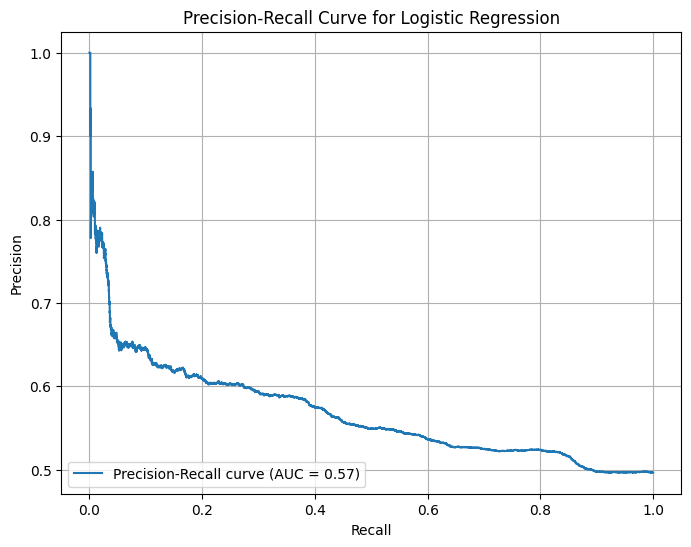


Logistic Regression Model Coefficients (Feature Importance):


,0
time_since_last_flap,0.034185
dist_to_next_pipe_x,-0.005489
abs_velocity,-0.019932
min_dist_to_boundary,-0.078373
dist_to_next_pipe_center_y,-0.128335


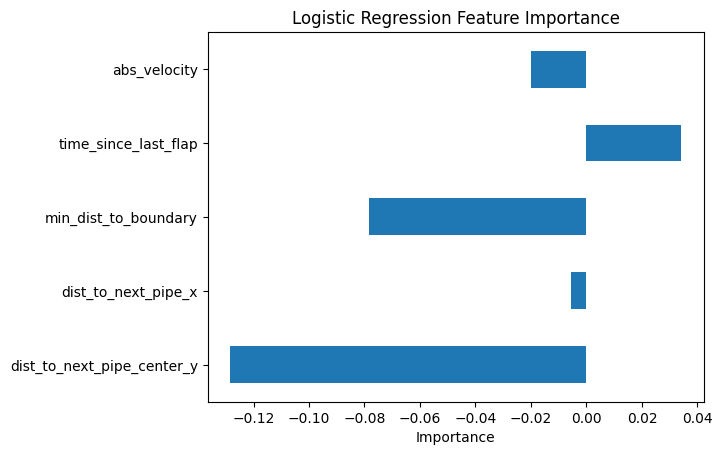

In [ ]:
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticregression', LogisticRegression(random_state=42, solver='liblinear'))
])

print("Training Logistic Regression pipeline...")
log_reg_pipeline.fit(X_train, y_train)
print("Training complete.")

y_pred_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC Score: {pr_auc:.4f}")

y_pred_lr = (y_pred_proba_lr >= 0.5).astype(int)

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_lr)
display(pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))


plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

logistic_model = log_reg_pipeline.named_steps['logisticregression']

coefficients = pd.Series(logistic_model.coef_[0], index=X_train.columns)
print("\nLogistic Regression Model Coefficients (Feature Importance):")
display(coefficients.sort_values(ascending=False))

coefficients.plot(kind="barh")
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

The logistic regression model achieves a ROC-AUC of 0.57, indicating modest but "better than random" ability to distinguish human and GA gameplay at the frame level. This aligns with earlier EDA and clustering results, which showed substantial overlap in behavioral patterns between agents. Feature coefficients suggest that GA gameplay is characterized by more consistent alignment with upcoming pipes and greater distance from boundaries, while human gameplay exhibits more reactive and less stable control.

#### Applying Random Forest classifier

Training Random Forest pipeline...
Training complete.

Random Forest ROC-AUC Score: 0.9417
Random Forest Precision-Recall AUC Score: 0.9401

Random Forest Confusion Matrix:


,Predicted 0,Predicted 1
Actual 0,5082,963
Actual 1,704,5260


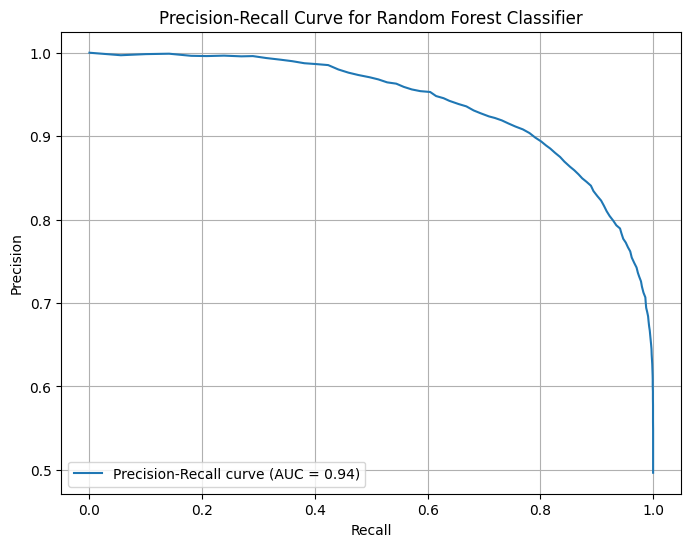


Random Forest Model Feature Importances:


,0
dist_to_next_pipe_center_y,0.335473
dist_to_next_pipe_x,0.248496
min_dist_to_boundary,0.209285
abs_velocity,0.106550
time_since_last_flap,0.100196


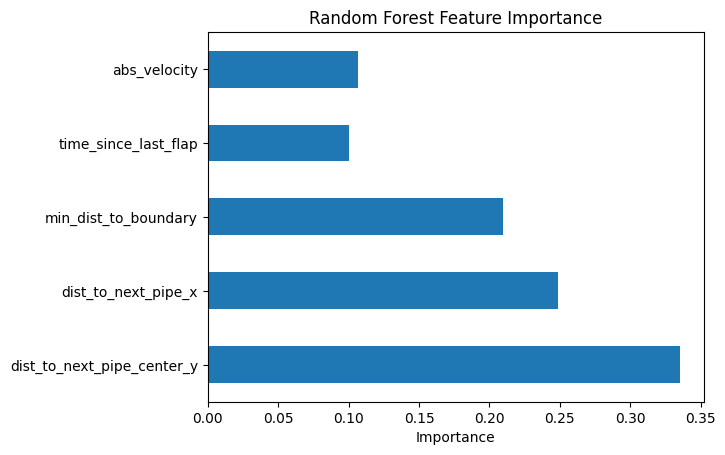

In [ ]:
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('randomforestclassifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

print("Training Random Forest pipeline...")
rf_pipeline.fit(X_train, y_train)
print("Training complete.")

y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nRandom Forest ROC-AUC Score: {roc_auc_rf:.4f}")

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_proba_rf)

pr_auc_rf = auc(recall_rf, precision_rf)
print(f"Random Forest Precision-Recall AUC Score: {pr_auc_rf:.4f}")

y_pred_rf = (y_pred_proba_rf >= 0.5).astype(int)

print("\nRandom Forest Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
display(pd.DataFrame(cm_rf, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1']))

plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, label=f'Precision-Recall curve (AUC = {pr_auc_rf:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest Classifier')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

random_forest_model = rf_pipeline.named_steps['randomforestclassifier']

feature_importances = pd.Series(random_forest_model.feature_importances_, index=X_train.columns)
print("\nRandom Forest Model Feature Importances:")
display(feature_importances.sort_values(ascending=False))

feature_importances.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.show()

The Random Forest classifier achieves a ROC-AUC of 0.94, demonstrating strong ability to distinguish between human and GA gameplay using engineered behavioral features. This performance contrast with the logistic regression model indicates that the behavioral differences between agents are predominantly non-linear. Feature importance analysis shows that spatial anticipation of upcoming pipes, particularly vertical alignment with the pipe gap—is the most discriminative factor, followed by horizontal distance to the next pipe and proximity to boundaries. These results suggest that the GA agent exhibits more structured and anticipatory control strategies compared to the more reactive human gameplay.

However, it is worth noting that, while performance is high at the frame level, future work should examine episode-level aggregation to account for temporal dependence between frames.

In [ ]:
print("\n--- Model Performance Comparison ---\n")
print(f"Logistic Regression ROC-AUC Score: {roc_auc:.4f}")
print(f"Logistic Regression Precision-Recall AUC Score: {pr_auc:.4f}")
print(f"\nRandom Forest ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"Random Forest Precision-Recall AUC Score: {pr_auc_rf:.4f}")


--- Model Performance Comparison ---

Logistic Regression ROC-AUC Score: 0.5683
Logistic Regression Precision-Recall AUC Score: 0.5678

Random Forest ROC-AUC Score: 0.9417
Random Forest Precision-Recall AUC Score: 0.9401


A comparison between Logistic Regression and Random Forest classifiers reveals a substantial performance gap. Logistic Regression achieves only modest discrimination (ROC-AUC ≈ 0.57, PR-AUC ≈ 0.57), indicating that human and GA gameplay behaviors are not linearly separable using the selected engineered features. In contrast, the Random Forest model performs exceptionally well (ROC-AUC ≈ 0.94, PR-AUC ≈ 0.94), demonstrating that the behavioral differences between agents are largely non-linear and driven by complex feature interactions.

Feature importance analysis from the Random Forest highlights that the most discriminative factors are spatial and anticipatory in nature. Vertical alignment with the next pipe’s gap (dist_to_next_pipe_center_y) is the strongest predictor, followed by horizontal distance to the next pipe (dist_to_next_pipe_x) and proximity to screen boundaries (min_dist_to_boundary). This suggests that the GA agent exhibits more precise and consistent spatial control when approaching pipes, whereas human gameplay is more variable and reactive.

Overfitting risks were mitigated through an explicit train–test split with stratified sampling, ensuring balanced class distributions across splits, and the use of pipelines to prevent data leakage during feature scaling. Additionally, the ensemble nature of Random Forests inherently improves generalization by averaging across multiple decorrelated decision trees.

Overall, these results indicate that while simple linear models fail to capture meaningful differences, non-linear models successfully identify structured, optimized behavioral patterns characteristic of the GA agent compared to human players.

### Human vs. GA analysis conclusion

This analysis investigated whether behavioral differences between human players and a Genetic Algorithm (GA) agent in Flappy Bird can be identified at the frame and pipe level using data-driven methods. Through structured cleaning, normalization, feature engineering, exploratory analysis, statistical testing, and modeling, clear behavioral differences were observed.

Exploratory analysis and clustering suggested that both agents occupy similar behavioral states, but with different frequencies and stability. Statistical tests confirmed that several engineered features exhibit meaningful distributional differences, even when accounting for large sample sizes. Most notably, supervised learning results showed that non-linear models (specifically Random Forests) can reliably distinguish human from GA gameplay, highlighting the importance of features relating to the position in accordance to the testing environment such as alignment with upcoming pipes.

A key limitation of this work is that frame-level data introduces strong time-based dependence (or in this case "frame-based" dependence), which was not explicitly modeled. Future work could incorporate sequence-based models (such as, for example, RNNs) better capture time-based strategy. Additionally, extending the analysis to multiple GA runs would allow for stronger generalization claims.

Overall, this project demonstrates that engineered behavioral features can effectively reveal and quantify differences between human and optimized AI (in this case specifically GA) gameplay strategies.

## Large language model application

### LLM-specific constants

In [ ]:
LLM_DECISION_INTERVAL = 3 # frames

### LLM client setup

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(
    api_key=userdata.get('GROQ_API_KEY'),
    base_url='https://api.groq.com/openai/v1',
)

###LLM observation

In [ ]:
def llm_observation(game):
  pipe = next(
      (p for p in game.pipes if p.x + game.PIPE_WIDTH > game.bird.x),
      None
  )

  if pipe:
    gap_center = (pipe.topY + pipe.botY) / 2
    gap_half = (pipe.botY - pipe.topY) / 2
    dy = (gap_center - game.bird.y) / gap_half
    dx = (pipe.x - game.bird.x) / game.GAME_WIDTH
  else:
    dy = 0.0
    dx = 1.0

  v = game.bird.velocity / 350
  movement = "FALLING" if v > 0 else "RISING"
  if abs(v) < 0.05:
    movement = "STABLE"

  return f"""
Vertical error (dy): {dy:.3f} (Lower means gap is above)
Velocity (v): {v:.3f} ({movement})
Horizontal dist (dx): {dx:.3f}

Situation:
- If dy < 0: Gap is ABOVE.
- If dy > 0: Gap is BELOW.
- If v is negative: You are already moving UP.

Reply: FLAP or NO_FLAP
""".strip()

### LLM agent class

In [ ]:
class LLMAgent:
  def __init__(self, client):
    self.client = client
    self.model = "llama-3.1-8b-instant" # faster model
    self.last_action = 0

    self.temperature = 0.0
    self.max_tokens = 5
    self.system_prompt = (
        "You are a Flappy Bird controller. Goal: Keep dy near 0.0.\n"
        "PHYSICS RULES:\n"
        "1. One FLAP gives a large upward boost. DO NOT flap twice in a row.\n"
        "2. If Velocity (v) is NEGATIVE (RISING), gravity will eventually slow you down. Usually, you should NOT flap while rising.\n"
        "\nDECISION LOGIC:\n"
        "- If dy < -0.1 AND v > 0 (Below gap and falling): FLAP.\n"
        "- If dy is near 0.0 AND v > 0.1 (At center but falling): FLAP once.\n"
        "- If |dy| < 0.4: You are safely inside the gap → NO_FLAP unless falling very fast.\n"
        "- If dy > 0.05 (Gap is below): NO_FLAP, let gravity do the work.\n"
        "- If v < -0.1 (rising), NEVER FLAP unless |dy| > 1.2\n"
        "- If v < -0.1 (Already rising): NO_FLAP (unless dy < -0.3 and you are very low).\n"
        "Reply ONLY with: FLAP or NO_FLAP"
    )

  def act(self, game):
    # emergency reflex and token saver
    if game.bird.y < 0:
      self.last_action = 0
      return 0
    if game.bird.y > game.GAME_HEIGHT * 0.90:
      self.last_action = 1
      return 1
    if len(game.pipes) == 0:
      action = 1 if game.bird.velocity > 250 else 0
      self.last_action = action
      return action

    obs = llm_observation(game)

    print(
        f"[LLM CALL] frame={game.frameId} "
        f"y={game.bird.y:.1f} "
        f"vel={game.bird.velocity:.1f} "
        f"pipes={len(game.pipes)}"
    )

    try:
      response = self.client.chat.completions.create(
          messages=[
              {"role": "system", "content": self.system_prompt},
              {"role": "user", "content": obs},
          ],
          model=self.model,
          temperature=self.temperature,
          max_completion_tokens=self.max_tokens,
      )

      text = response.choices[0].message.content.strip().upper()

      if "NO_FLAP" in text:
        action = 0
      elif "FLAP" in text:
        action = 1
      else:
        action = 0

      print(
          f"[LLM DECISION] frame={game.frameId} "
          f"-> {'FLAP' if action else 'NO_FLAP'} "
          f"(raw='{text}')"
      )

      self.last_action = action
      return action

    except Exception as e:
      print(f"Groq API Error: {e}")
      return self.last_action

### Replay LLM episode

In [ ]:
print("Replaying LLM agent...")

game = Game(GAME_WIDTH, GAME_HEIGHT, record=True)
game.AGENT_TYPE = "llm"
game.auto_reset = False

agent = LLMAgent(client)

while not game.gameIsOver and game.frameId < 2000:
    if game.frameId % LLM_DECISION_INTERVAL == 0:
      # physics pause to wait for answer
      action = agent.act(game)
    else:
      action = 0

    if action == 1 and game.bird.flapCooldown <= 0:
      game.bird.isFlapping = True
      game.bird.flapWings()
      game.bird.flapCooldown = 0.15

    game.gameLoop(FIXED_DT)

Replaying LLM agent...
[LLM CALL] frame=180 y=311.8 vel=-12.0 pipes=1
[LLM DECISION] frame=180 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=183 y=311.8 vel=5.6 pipes=1
[LLM DECISION] frame=183 -> FLAP (raw='FLAP')
[LLM CALL] frame=186 y=298.6 vel=-257.5 pipes=1
[LLM DECISION] frame=186 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=189 y=286.3 vel=-239.9 pipes=1
[LLM DECISION] frame=189 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=192 y=274.8 vel=-222.4 pipes=1
[LLM DECISION] frame=192 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=195 y=264.3 vel=-204.9 pipes=1
[LLM DECISION] frame=195 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=198 y=254.6 vel=-187.3 pipes=1
[LLM DECISION] frame=198 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=201 y=245.8 vel=-169.8 pipes=1
[LLM DECISION] frame=201 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=204 y=237.9 vel=-152.3 pipes=1
[LLM DECISION] frame=204 -> NO_FLAP (raw='NO_FLAP')
[LLM CALL] frame=207 y=230.8 vel=-134.7 pipes=1
[LLM DECISION] frame=207 -> NO_FLAP (ra

## Export LLM game zip

### Export frames.csv

In [ ]:
frames_headers = list(game.frameStates[0].keys())
frames_csv = "frames.csv"

with open(frames_csv, "w", newline="", encoding="utf-8") as f:
  writer = csv.writer(f)
  writer.writerow(frames_headers)
  writer.writerows(
      [[frame[h] for h in frames_headers] for frame in game.frameStates]
  )

### Export LLM metadata.csv

In [ ]:
game.metadata.update({
    "agent_type": "llm",
    "llm_model": agent.model,
    "llm_temperature": agent.temperature,
    "llm_max_tokens": agent.max_tokens,
    "llm_system_prompt": agent.system_prompt,
    "llm_decision_interval": LLM_DECISION_INTERVAL,
    "max_frames": MAX_FRAMES,
})

metadata_csv = "metadata.csv"
meta_keys = list(game.metadata.keys())
meta_values = list(game.metadata.values())

with open(metadata_csv, "w", newline="", encoding="utf-8") as f:
  writer = csv.writer(f)
  writer.writerow(meta_keys)
  writer.writerow(meta_values)


### Zip & download game

In [ ]:
now = datetime.datetime.now(ZoneInfo("Europe/Zagreb"))
timestamp = now.strftime("%Y%m%d_%H%M%S")
zip_filename = f"flappy_bird_llm_replay_{timestamp}.zip"

with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
  zipf.write(frames_csv)
  zipf.write(metadata_csv)

files.download(zip_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>